In [1]:
import numpy as np 
import pandas as pd
import os
import numpy.ma as ma
from datetime import datetime, timedelta

import seaborn as sns

from math import floor
import time
import matplotlib.pyplot as plt
import dexplot as dxp
import scipy
from matplotlib import rcParams

from scipy.stats import ttest_ind
#plt.style.use('classic')

In [2]:
def within_1min(tl1, tl2): 
    dates = np.array([])
    tl1 = np.array(tl1)
    tl2 = np.array(tl2)
    for i in tl1: 
        qq = np.where(np.abs((i-tl2))<timedelta(minutes = 1))[0]
        if len(qq) == 0:
            dates = np.append(dates, i)
            
    return dates

In [3]:
## datetime_radar_vec
## datetime_tor_vec



In [4]:
def group_counts(lst, group_sizes):
    
    if isinstance(group_sizes[0], int):
        counts = np.array([])
        for i in range(0,len(group_sizes)-1):
            count_i = len(np.where((np.array(lst)>group_sizes[i]) & (np.array(lst)<group_sizes[i+1]))[0])
            counts = np.append(counts, count_i) 
    else: 
        counts = np.array([])
        for i in group_sizes:
            count_i = (lst == i).sum()
            counts = np.append(counts, count_i) 
    return counts

In [5]:
def group_counts_cats(lst_num, lst_cat, group_sizes, cats):
    counts = np.array([])
    n_events = np.array([])
    for i in range(0,len(group_sizes)-1):
        #print(i)
        for j in cats: 
            count_i = ((np.array(lst_num)>=group_sizes[i]) & (np.array(lst_num)<group_sizes[i+1]) & (lst_cat == j)).sum()
            xx = np.where((np.array(lst_num)>=group_sizes[i]) & (np.array(lst_num)<group_sizes[i+1]) & (lst_cat == j))
            str_vec = [datetime.strftime(i, '%m/%d/%Y') for i in np.array(datetime_vec)[xx[0]]]
            #print(np.unique(str_vec))
            n_events = np.append(n_events, np.unique(str_vec).shape)
            counts = np.append(counts, count_i) 
    return counts, n_events

In [6]:
## Importing data set
lst_str_cols = ['Time (UTC)']
dict_dtypes = {x : 'str'  for x in lst_str_cols}

df = pd.read_excel('./qlcs_years16_17_19_final.xlsx', engine='openpyxl', dtype=dict_dtypes)


In [7]:
df["Date"][0]

Timestamp('2019-01-04 00:00:00')

In [8]:
radar_dates = df["Date"]
radar_times = df["Time (UTC)"]



In [12]:
dat = np.load('./Rap_Obs_full_final_6.npz', allow_pickle = True)
#dat_361 = np.load('./Rap_Obs_ind_361.npz', allow_pickle = True)
rh_diff = dat['rh03']-dat['rh36']

data_dict = {}

for k in dat.files: 
    
    if dat[k].size <500:
        #data_dict[k] = dat[k]
        print(k)
    else:
        print(k)
        if dat[k].size>600:
            mult = 4
        else: 
            mult = 1
            
        if mult == 4: 
            data_dict[k] = np.reshape(dat[k], (-1,mult))
        else:
            data_dict[k] = dat[k]

n_points
nskip
start_point
tor_dates
tor_times
tor_mech
hsi_indices
other_indices
tor_index
tas_indices
warm_indices
cool_indices
fgen_925
fgen_area_925
vort_925
vort_area_925
sbcape
sbcin
threecape
threecin
mucape
mucin
mlcape
mlcin
sbcape_model
srh03
srh01
bs01
bs03
bs06
vort
vort_area
fgen
fgen_area
div
div_area
lcl
stp
scp
lr01
lr03
lr36
nst
fgen_850
fgen_area_850
vort_850
vort_area_850
div_850
div_area_850
fgen_700
rh03
rh36
fgen_area_700
vort_700
vort_area_700
div_700
div_area_700


In [13]:
data_dict['rh_diff'] = np.reshape(rh_diff, (-1,4))

In [14]:
date   = df["Date"]
times  = df["Time (UTC)"]
times  = [str(i) for i in times]
lat    = df["Lat"]
lon    = -np.abs(df["Lon"])
ef     = df["EF Rating"]

mech   = df["Mechanism"]
llc    = df["LLC Strength (kts)"]
lt     = df["Lead Time (min)"]

In [15]:
## Creating array of local times

time_formal  = [i[:2] + ':' + i[2:4] for i in times]
timevec      = [datetime.strptime(i,'%H:%M') for i in time_formal]
datetime_vec = [datetime.combine(datetime.date(date[i]), datetime.time(timevec[i])) for i in range(0, len(timevec))] # UTC Time

#hour_offset  = [-floor(i/15) for i in lon]
lto = np.load('lto.npz', allow_pickle = True)
hour_offset = lto['lto']

ltc_time = [datetime_vec[i] - timedelta(hours = hour_offset[i]) for i in range(0,len(hour_offset))]

## finding the local hour of occurence
local_hour = np.array([])

for i in ltc_time: 
    local_hour = np.append(local_hour, i.hour)
    #print(i)
    
local_month = np.array([])

for i in ltc_time: 
    local_month = np.append(local_month, i.month)

In [16]:
n = 0
not_repeated = np.array([True])

## Finding Repeat Environments
dum_fn = datetime_vec[0].strftime("%d/%m/%Y %H:%M")
for i in datetime_vec[1:]:
    if i.strftime("%d/%m/%Y%H") == dum_fn: 
        n+=1
        not_repeated = np.append(not_repeated, False)
    else: 
        not_repeated = np.append(not_repeated, True)
        
    dum_fn = i.strftime("%d/%m/%Y%H")
    

In [17]:
## Data lower than 500m. 
DVlt500 = np.array([])
n = 0
for i in df['Lowest tilt elevation (m)']:
    if i<500:
        DVlt500 = np.append(DVlt500, df['LLC Strength (kts)'][n])
    else: 
        DVlt500 = np.append(DVlt500, np.nan)
    n+=1
        

In [18]:
## Inserting LTC time into the dataframe


if  not ('Local Time' in df.columns):
    df.insert(df.columns.get_loc("Time (UTC)") + 1, 'Local Time', ltc_time)
if  not ('Local Hour' in df.columns):
    df.insert(df.columns.get_loc("Local Time") + 1, 'Local Hour', local_hour)
    
if not ('Local Month' in df.columns):
    df.insert(df.columns.get_loc("Local Hour") + 1, 'Local Month', local_month)
    
if not ('LLC<500m' in df.columns): 
    df.insert(df.columns.get_loc("LLC Strength (kts)") + 1, 'LLC<500m', DVlt500)

if not ('Not Repeated' in df.columns): 
    df.insert(df.columns.get_loc("Comments") + 1, 'Not Repeated', not_repeated)
    
if not ('Path Length (miles)' in df.columns):
    df.insert(df.columns.get_loc('Not Repeated')+ 1, 'Path Length (miles)', np.array(lto['path_len']))

if not ('Width' in df.columns):
    df.insert(df.columns.get_loc('Path Length (miles)')+ 1, 'Width', np.array(lto['tor_width']))

if not ('Injuries' in df.columns):
    df.insert(df.columns.get_loc('Width')+ 1, 'Injuries', np.array(lto['injuries']))

if not ('Deaths' in df.columns):
    df.insert(df.columns.get_loc('Injuries')+ 1, 'Deaths', np.array(lto['deaths']))
    
if not ('Storm Speed (km/hr)' in df.columns):
    df.insert(df.columns.get_loc('Deaths')+ 1, 'Storm Speed (km/hr)', np.array(lto['speed']))
    
if not ('Duration (min)' in df.columns):
    df.insert(df.columns.get_loc('Storm Speed (km/hr)')+ 1, 'Duration (min)', np.array(lto['tor_time'])/60)

In [19]:
years = [i.year for i in ltc_time]


years = np.array(years)
(years == 2016).sum()

103

In [20]:
for i in df.columns: 
    print(i)

Date
State 
Time (UTC)
Local Time
Local Hour
Local Month
Lat
Lon
EF Rating
Season
Length of QLCS (km)
Lowest tilt elevation (m)
ML Circ >15min prior to LL Circ?
MLC Strength (kts) (if present)
LLC Strength (kts)
LLC<500m
Lead Time (min)
Adjacent Ciruclation within 25km? 
Mechanism
Comments
Not Repeated
Path Length (miles)
Width
Injuries
Deaths
Storm Speed (km/hr)
Duration (min)
Unnamed: 16
Evenly spaced 
No ML circulation


In [21]:
# Redoing mechanisms and Adding a Clear HSI column

## Redefining mechanism
mechanism_redone = np.array([])

for i in df["Mechanism"]:
    if 'HSI' in i: 
        mechanism_redone = np.append(mechanism_redone, 'SID')
    elif 'T&S' in i: 
        mechanism_redone  = np.append(mechanism_redone, 'PMD')
    else: 
        mechanism_redone  = np.append(mechanism_redone, 'Other')

## Clear HSI?         
n = 0
x = 0

# clear_hsi = np.array([])
    
# for i in range(0,len(df['Comments'])): 
#     if isinstance(df['Comments'][i], float):
#         clear_hsi = np.append(clear_hsi, mechanism_redone[i])
#         x+=1
#         continue
#     if (('Clear HSI' in df['Comments'][i]) or ('clear HSI' in df['Comments'][i])) and (mechanism_redone[i] == 'H&S'): 
#         n += 1 
#         clear_hsi = np.append(clear_hsi, 'Clear HSI')
#     else: 
#         clear_hsi = np.append(clear_hsi, mechanism_redone[i])
#     x+=1
    
## Redefining Season  
season = np.array([])

for i in datetime_vec:
    if (i.month < 4) or (i.month)>9: 
        #print('Cool')
        season = np.append(season, 'Cool')
    else: 
        #print('Warm')
        season = np.append(season, 'Warm')

        
## Non-Zero Lead Time
ltnz = np.array([])
    
for i in df['Lead Time (min)']:
    if i>0: 
        ltnz = np.append(ltnz, i)
    else: 
        ltnz = np.append(ltnz, np.nan)
if  not ('LLDV (m/s)' in df.columns): 
    df.insert(df.columns.get_loc('LLC Strength (kts)') + 1, 'LLDV (m/s)', df['LLC Strength (kts)']/1.94384)
if  not ('Mechanism redone' in df.columns):
    df.insert(df.columns.get_loc("Mechanism") + 1, 'Mechanism redone', mechanism_redone)
# if  not ('Clear HSI?' in df.columns):
#     df.insert(df.columns.get_loc("Comments")  + 1, 'Clear HSI?', clear_hsi)
if  not ('Lead Time Non-Zero' in df.columns): 
    df.insert(df.columns.get_loc('Lead Time (min)') + 1, 'Lead Time Non-Zero', ltnz)
    
df['Season']             = tuple(season)

In [22]:
## fraction of cases above latitude by season

((df['Season'] == 'Warm') & np.array(df['Lat']<37)).sum()

158

## Bootstrapping

- A z-test for difference in proportions won't work, because the two proportions are not independent from one another.
- Let's use a boostrap.

- First we define our statistic function, let's call it "prop_has" (proportion of HSI and Stretching)

In [23]:
def prop_has(data): 
    s = (data == 'H&S').sum()
    return s/np.size(data)

In [24]:
ef_max = np.array([])

for i in df['EF Rating']:
    if isinstance(i, str):
        ef_max = np.append(ef_max, -1)
    else:
        ef_max = np.append(ef_max, i)
    

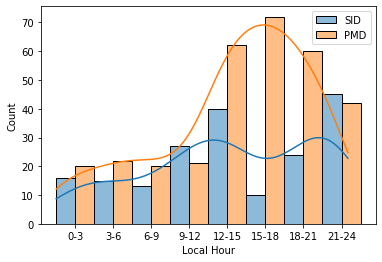

In [25]:
fig, ax = plt.subplots()
xticks = np.arange(0, 27, 3)
g = sns.histplot(data = df, x = 'Local Hour', hue = 'Mechanism redone', hue_order = ['SID', 'PMD'], multiple="dodge", kde = True, \
            bins = xticks, stat = 'count')

bin_labels = ['0-3','3-6', '6-9', '9-12','12-15', '15-18', '18-21','21-24']

ax.get_legend().set_title('')
ax.set_xticks(np.arange(1.5,24.5,3))
ax.set_xticklabels(bin_labels);



In [26]:
10/(530-319)

0.04739336492890995

In [27]:
gcc[0::2]

NameError: name 'gcc' is not defined

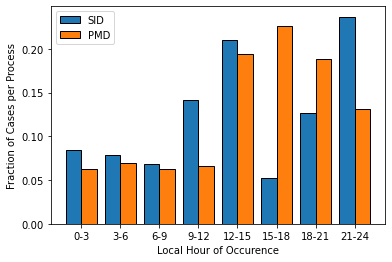

In [28]:
## normalized diurnal cycle

## for normalized histogram
gc = group_counts(df['Mechanism redone'], ['SID', 'PMD'])

#gcc = group_counts_cats(df['Local Hour'], df['Mechanism redone'], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], ['HSI', 'T&S'])
[gcc, n_events] = group_counts_cats(df['Local Hour'], df['Mechanism redone'], [0,3,6,9,12,15,18,21,24], ['SID', 'PMD'])
g_hsi = gcc[0::2]/gc[0]
g_tas = gcc[1::2]/gc[1]

ne_hsi = n_events[0::2]
ne_tas = n_events[1::2]

ne_hstr = [str(int(i)) for i in ne_hsi]
ne_tstr = [str(int(i)) for i in ne_tas]

figure, ax = plt.subplots()

plt.bar(np.arange(1.5,24,3)-0.6, g_hsi, width=1.2, align='center', label = 'SID', edgecolor = 'black')
plt.bar(np.arange(1.5,24,3)+0.6, g_tas, width=1.2, align='center', label = 'PMD', edgecolor = 'black')
# for i in zip(np.arange(1.5,24,3)-1, g_hsi + 0.005, ne_hstr):
#     plt.text(i[0], i[1], s = i[2])
    
# for i in zip(np.arange(1.5,24,3)+0.2, g_tas + 0.005, ne_tstr):
#     plt.text(i[0], i[1], s = i[2])
    
plt.legend()


plt.xlabel('Local Hour of Occurence')
plt.ylabel('Fraction of Cases per Process')
plt.xticks(np.arange(1.5,24,3));
ax.set_xticklabels(bin_labels);
figure.savefig("../Figures/lst_3h.png", bbox_inches='tight', dpi = 700)


In [29]:
for i in tuple((bin_labels, g_tas)):
    print(i)

['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']
[0.06269592 0.06896552 0.06269592 0.06583072 0.19435737 0.22570533
 0.18808777 0.13166144]


In [30]:
np.where(((df['Local Hour']>=15)&(df['Local Hour']<18))&(df['Mechanism redone'] == 'T&S'))[0].shape

(0,)

In [31]:
np.size(np.where(df['Mechanism redone'] == 'T&S')[0])

0

In [32]:
(((df['Local Hour']>=15)&(df['Local Hour']<=18))&(df['Mechanism redone'] == 'T&S')).sum()

0

Cool
Warm


/tmp/ipykernel_15560/3677725495.py:14: RuntimeWarning: invalid value encountered in long_scalars
  frac_season_hsi = np.append(frac_season_hsi, i_hsi/n_hsi)
/tmp/ipykernel_15560/3677725495.py:15: RuntimeWarning: invalid value encountered in long_scalars
  frac_season_tas = np.append(frac_season_tas, i_tas/n_tas)


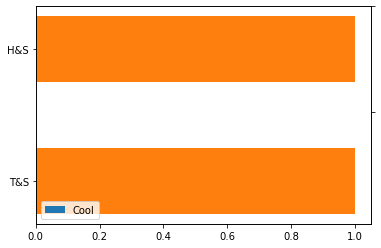

In [33]:
fig, ax = plt.subplots()

frac_season_hsi = np.array([])
frac_season_tas = np.array([])

for i in ['Cool', 'Warm']:
    print(i)
    i_hsi = ((df['Season'] == i) & (df['Mechanism redone'] == 'H&S')).sum()
    i_tas = ((df['Season'] == i) & (df['Mechanism redone'] == 'T&S')).sum()
    n_hsi = (df['Mechanism redone'] == 'H&S').sum()
    n_tas = (df['Mechanism redone'] == 'T&S').sum()
    
    
    frac_season_hsi = np.append(frac_season_hsi, i_hsi/n_hsi)
    frac_season_tas = np.append(frac_season_tas, i_tas/n_tas)
    


_ = ax.barh(1, 1, align='center', height = 0.5,color = 'tab:orange', label = 'Warm')
_ = ax.barh(2, 1, align='center', color = 'tab:orange', height = 0.5,)

ax1 = ax.twinx()

_ = ax1.barh(1, frac_season_hsi[0], align='center', color = 'tab:blue',height = 0.5, label = 'Cool')
_ = ax1.barh(2, frac_season_tas[0], align='center', color = 'tab:blue',height = 0.5,)


#_ = plt.bar(np.arange(0,2)+0.2, frac_season_tas, width=0.4, align='center', label = 'T&S', edgecolor = 'black')

ax.set_yticks([1,2])
ax.set_yticklabels(['T&S','H&S'])

ax1.set_yticks([1,2])
ax1.set_yticklabels(['',''])

fig.set_size_inches(6, 4)
#fig.set_size_inches(12,8)
#plt.ylabel('Fraction of Cases by Mechanism')
#plt.xlabel('Season', fontsize = 12)
#plt.ylabel('Fraction of Cases per Mechanism', fontsize = 12)

plt.legend(fontsize = 10)

Cool
Warm


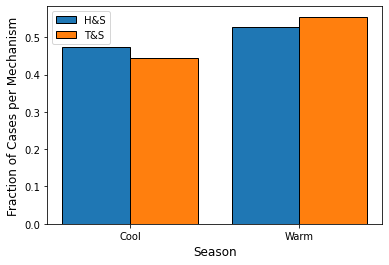

In [34]:
## Horizontal bar graph?  

fig, ax = plt.subplots()

frac_season_hsi = np.array([])
frac_season_tas = np.array([])

for i in ['Cool', 'Warm']:
    print(i)
    i_hsi = ((df['Season'] == i) & (df['Mechanism redone'] == 'SID')).sum()
    i_tas = ((df['Season'] == i) & (df['Mechanism redone'] ==  'PMD')).sum()
    n_hsi = (df['Mechanism redone'] == 'SID').sum()
    n_tas = (df['Mechanism redone'] == 'PMD').sum()
    
    
    frac_season_hsi = np.append(frac_season_hsi, i_hsi/n_hsi)
    frac_season_tas = np.append(frac_season_tas, i_tas/n_tas)
    


_ = plt.bar(np.arange(0,2)-0.2, frac_season_hsi, width=0.4, align='center', label = 'H&S', edgecolor = 'black')
_ = plt.bar(np.arange(0,2)+0.2, frac_season_tas, width=0.4, align='center', label = 'T&S', edgecolor = 'black')

ax.set_xticks([0,1])
ax.set_xticklabels(['Cool','Warm'])
fig.set_size_inches(6, 4)
#fig.set_size_inches(12,8)
#plt.ylabel('Fraction of Cases by Mechanism')
plt.xlabel('Season', fontsize = 12)
plt.ylabel('Fraction of Cases per Mechanism', fontsize = 12)

plt.legend(fontsize = 10)

In [35]:
frac_season_tas

array([0.44514107, 0.55485893])

(6,)
(21,)


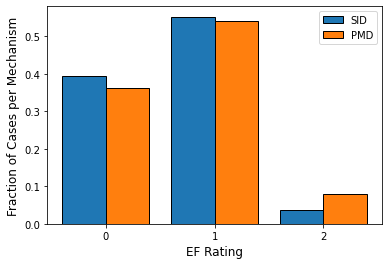

In [36]:
fig, ax = plt.subplots()

frac_ef_hsi = np.array([])
frac_ef_tas = np.array([])

#str_vec = [datetime.strftime(i, '%m/%d/%Y') for i in np.array(datetime_vec)[xx[0]]]

for i in range(0,3):
    i_hsi = ((df['EF Rating'] == i) & (df['Mechanism redone'] == 'SID')).sum()
    i_tas = ((df['EF Rating'] == i) & (df['Mechanism redone'] == 'PMD')).sum()
    w_hsi = np.where(((df['EF Rating'] == i) & (df['Mechanism redone'] == 'SID')))
    w_tas = np.where(((df['EF Rating'] == i) & (df['Mechanism redone'] == 'PMD')))
    if i == 2:
        str_vec_hsi = [datetime.strftime(i, '%m/%d/%Y') for i in np.array(datetime_vec)[w_hsi[0]]]
        str_vec_tas = [datetime.strftime(i, '%m/%d/%Y') for i in np.array(datetime_vec)[w_tas[0]]]
        
        print(np.unique(np.array(str_vec_hsi)).shape)
        print(np.unique(np.array(str_vec_tas)).shape)

    n_hsi = (df['Mechanism redone'] == 'SID').sum()
    n_tas = (df['Mechanism redone'] == 'PMD').sum()
    
    
    frac_ef_hsi = np.append(frac_ef_hsi, i_hsi/n_hsi)
    frac_ef_tas = np.append(frac_ef_tas, i_tas/n_tas)
    


_ = plt.bar(np.arange(0,3)-0.2, frac_ef_hsi, width=0.4, align='center', label = 'SID', edgecolor = 'black')
_ = plt.bar(np.arange(0,3)+0.2, frac_ef_tas, width=0.4, align='center', label = 'PMD', edgecolor = 'black')

ax.set_xticks([0, 1, 2])

#plt.ylabel('Fraction of Cases by Mechanism')
plt.xlabel('EF Rating',fontsize = 12)
plt.ylabel('Fraction of Cases per Mechanism',fontsize = 12)
plt.legend()
plt.savefig('../Figures/ef_mech.png', dpi = 300 )

In [37]:
df['LLC Strength (kts)'][(df['Mechanism redone'] == 'H&S')].mean()

nan

In [38]:
dat = [139/319, 59/190]

[Text(-0.07, 0, 'H&S'), Text(0.07, 0, 'T&S')]

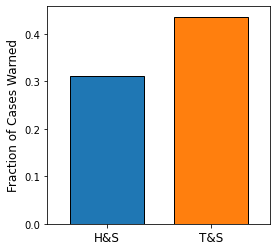

In [39]:
%matplotlib inline
fig, ax = plt.subplots(figsize = [4,4])
_ = plt.bar(-0.07, dat[1], width=0.1, align='center', label = 'H&S', edgecolor = 'black')
_ = plt.bar(0.07, dat[0], width=0.1, align='center', label = 'H&S', edgecolor = 'black')
#_ = plt.bar(np.arange(0,2)+0.2, frac_season_tas, width=0.4, align='center', label = 'T&S', edgecolor = 'black')
plt.ylabel('Fraction of Cases Warned', fontsize = 12)
plt.xlim([-0.15,0.15])
ax.set_xticks([-0.07, 0.07])
ax.set_xticklabels(['H&S','T&S'], fontsize = 12)

In [40]:
np.arange(0,0.5)

array([0.])

In [41]:
(df['Mechanism redone'] == 'H&S').sum()

0

In [42]:
(df['Lead Time (min)'][(df['Mechanism redone'] == 'H&S')]>0).sum()

0

In [43]:
(df['Lead Time (min)']>0).sum()

202

In [44]:
df['Mechanism redone']

0        SID
1        SID
2      Other
3        PMD
4        PMD
       ...  
525      PMD
526      PMD
527      PMD
528      PMD
529      PMD
Name: Mechanism redone, Length: 530, dtype: object

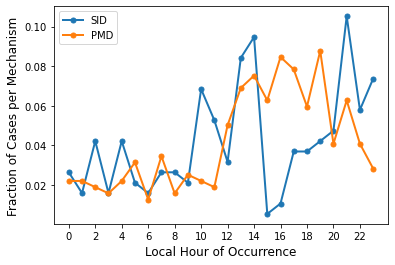

In [45]:
## normalized diurnal cycle
## for normalized histogram
gc = group_counts(df['Mechanism redone'], ['SID', 'PMD'])
gcc,_ = group_counts_cats(df['Local Hour'], df['Mechanism redone'], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], ['SID', 'PMD'])

#gcc = group_counts_cats(df['Local Hour'], df['Mechanism redone'], [0,3,6,9,12,15,18,21,24], ['HSI', 'PMD'])
g_hsi = gcc[0::2]/gc[0]
g_tas = gcc[1::2]/gc[1]

figure, ax = plt.subplots()

plt.plot(np.arange(0.5,24.5,1), g_hsi, label = 'SID', marker = '.', markersize = 10, linewidth = 2)
plt.plot(np.arange(0.5,24.5,1), g_tas, label = 'PMD', marker = '.', markersize = 10, linewidth = 2)
plt.legend()
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Local Hour of Occurrence', fontsize = 12)
plt.ylabel('Fraction of Cases per Mechanism', fontsize = 12)
#plt.ylabel('Frequency', fontsize = 12)
plt.xticks(np.arange(0.5,24.5,2));
ax.set_xticklabels(np.arange(0,24,2));

figure.savefig("../Figures/diurnal_cycle.png", bbox_inches='tight', dpi = 500)



In [46]:
mechi = 'SID'
x = 0
c = np.array([])
f = np.array([])
T =  (df['Mechanism redone'] == 'PMD').sum()
for i in range(0,24):
    #print(i)
#     c = np.append(c, ((df['Local Hour'] == i) & (df['Mechanism redone'] == mechi) & (df['Season'] == 'Cool')).sum()/
#                  ((df['Local Hour'] == i) & (df['Mechanism redone'] == mechi)).sum())
#     f = np.append(f, ((df['Local Hour'] == i) & (df['Mechanism redone'] == mechi)).sum()/T)
    c = np.append(c, ((df['Local Hour'] == i) & (df['Season'] == 'Cool')).sum()/
                 ((df['Local Hour'] == i)).sum())
    f = np.append(f, ((df['Local Hour'] == i) ).sum()/T)
#     print(((df['Local Hour'] == i) & (df['Mechanism redone'] == 'PMD')).sum())
#     print(((df['Local Hour'] == i) & (df['Mechanism redone'] == 'PMD') & (df['Season'] == 'Cool')).sum())
#     print(((df['Local Hour'] == i) & (df['Mechanism redone'] == 'PMD') & (df['Season'] == 'Warm')).sum())

In [47]:
f.size

24

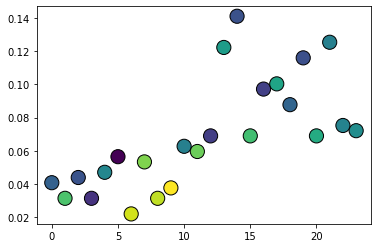

In [48]:
x = np.arange(0,24,1)
plt.scatter(x,f, c = c, ec = 'k', s = 200)

In [49]:
c

array([0.38461538, 0.6       , 0.35714286, 0.3       , 0.46666667,
       0.22222222, 0.71428571, 0.64705882, 0.7       , 0.75      ,
       0.45      , 0.63157895, 0.31818182, 0.51282051, 0.35555556,
       0.59090909, 0.32258065, 0.53125   , 0.39285714, 0.35135135,
       0.54545455, 0.45      , 0.45833333, 0.47826087])

In [50]:
# fig, ax = plt.subplots()
# ax = sns.histplot(data = df, x = 'Local Hour', hue = 'Mechanism redone', hue_order = ['H&S', 'T&S'], multiple="dodge", kde = True, \
#             bins = [-0.1,2.9,5.9,8.9,11.9,14.9,17.9,20.9,23.9], stat = 'count')

# bin_labels = ['0-3','3-6', '6-9', '9-12','12-15', '15-18', '18-21','21-24']
# ax.set_xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5, 22.5])
# ax.set_xticklabels(bin_labels);



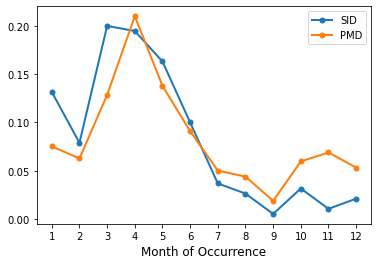

In [51]:
## normalized diurnal cycle

## for normalized histogram
gc = group_counts(df['Mechanism redone'], ['SID', 'PMD'])

gcc,_ = group_counts_cats(df['Local Month'], df['Mechanism redone'], [1,2,3,4,5,6,7,8,9,10,11,12,13], ['SID', 'PMD'])
#gcc = group_counts_cats(df['Local Hour'], df['Mechanism redone'], [0,3,6,9,12,15,18,21,24], ['HSI', 'T&S'])
g_hsi = gcc[0::2]/gc[0]
g_tas = gcc[1::2]/gc[1]

figure, ax = plt.subplots()
figure.set_size_inches(6, 4)

plt.plot(np.arange(1.5,13.5,1), g_hsi, label = 'SID', marker = '.', markersize = 10, linewidth = 2)
plt.plot(np.arange(1.5,13.5,1), g_tas, label = 'PMD', marker = '.', markersize = 10, linewidth = 2)
plt.legend()
plt.xlabel('Month of Occurrence', fontsize = 12)
#plt.ylabel('Frequency')
plt.xticks(np.arange(1.5,13.5,1), fontsize = 10);
plt.yticks(fontsize = 10)
ax.set_xticklabels(np.arange(1,13,1));

#figure.savefig("../Figures/monthly_cycle.pdf", bbox_inches='tight', dpi = 500)

findfont: Font family ['sans_serif'] not found. Falling back to DejaVu Sans.


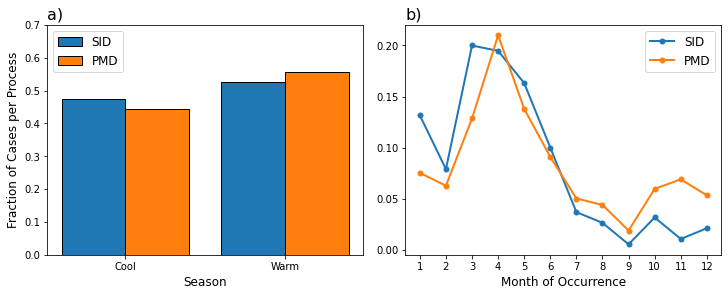

In [52]:
## Figure 5

fig, axs = plt.subplot_mosaic([['a)', 'b)']],
                              constrained_layout=True, figsize=(10,4))
axs['a)'].bar(np.arange(0,2)-0.2, frac_season_hsi, width=0.4, align='center', label = 'SID', edgecolor = 'black')
axs['a)'].bar(np.arange(0,2)+0.2, frac_season_tas, width=0.4, align='center', label = 'PMD', edgecolor = 'black')

axs['a)'].set_xticks([0,1])
axs['a)'].set_xticklabels(['Cool','Warm'])
axs['a)'].set_yticks(np.arange(0,0.75,0.1))

axs['a)'].set_xlabel('Season', fontsize = 12)
axs['a)'].set_ylabel('Fraction of Cases per Process', fontsize = 12)

axs['a)'].legend(loc = 'upper left', fontsize = 12)

axs['b)'].plot(np.arange(1.5,13.5,1), g_hsi, label = 'SID', marker = '.', markersize = 10, linewidth = 2)
axs['b)'].plot(np.arange(1.5,13.5,1), g_tas, label = 'PMD', marker = '.', markersize = 10, linewidth = 2)
axs['b)'].legend(loc = 'upper right', fontsize = 12)
axs['b)'].set_xlabel('Month of Occurrence', fontsize = 12)
#plt.ylabel('Frequency')
axs['b)'].set_xticks(np.arange(1.5,13.5,1));
axs['b)'].set_xticklabels(np.arange(1,13,1));

for label, ax in axs.items():
    ax.set_title('', fontstyle='italic')
    ax.set_title(label, fontfamily='sans_serif', loc='left', fontsize=16)


fig.savefig("../Figures/Rev2/fig6.png", bbox_inches='tight', dpi = 1000)    


In [53]:
np.arange(0,0.9,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

<AxesSubplot:xlabel='Mechanism redone', ylabel='Path Length (miles)'>

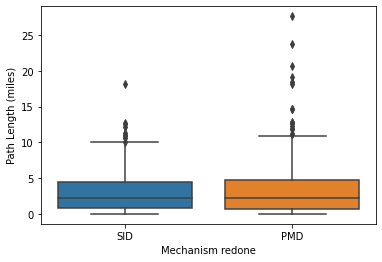

In [54]:
sns.boxplot(x = 'Mechanism redone' , y = 'Path Length (miles)', order = ['SID', 'PMD'], data=df, showfliers = True)

<AxesSubplot:xlabel='Mechanism redone', ylabel='Duration (min)'>

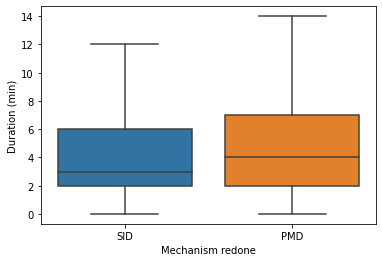

In [55]:
sns.boxplot(x = 'Mechanism redone' , y = 'Duration (min)', order = ['SID', 'PMD'], data=df, showfliers = False)

<AxesSubplot:xlabel='Mechanism redone', ylabel='Injuries'>

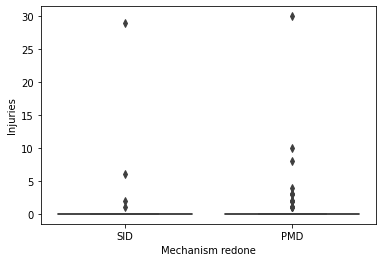

In [56]:
sns.boxplot(x = 'Mechanism redone' , y = 'Injuries', order = ['SID', 'PMD'], data=df)

Text(0, 0.5, 'Low-Level $\\Delta V$')

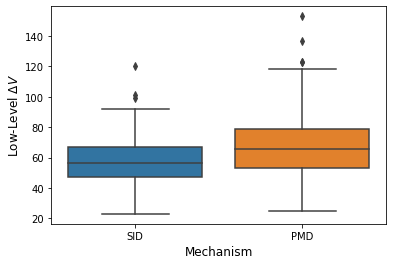

In [57]:
f, ax = plt.subplots()
ax = sns.boxplot(x = 'Mechanism redone' , y = 'LLC Strength (kts)', order = ['SID', 'PMD'], data=df) ## Figure 9a
plt.xlabel('Mechanism', fontsize = 12)
plt.ylabel('Low-Level '+ r'$\Delta V$', fontsize = 12)

Text(0, 0.5, 'Sampling Height (m)')

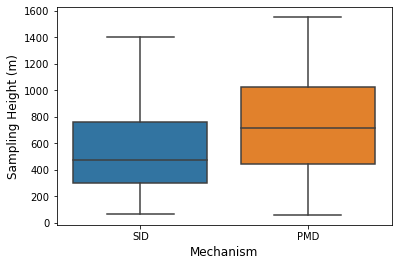

In [58]:
f, ax = plt.subplots()
ax = sns.boxplot(x = 'Mechanism redone' , y = 'Lowest tilt elevation (m)', order = ['SID', 'PMD'], data=df) ## Figure 9a
plt.xlabel('Mechanism', fontsize = 12)
plt.ylabel('Sampling Height (m)', fontsize = 12)
# handles, _ = ax.get_legend_handles_labels()

# l = plt.legend(handles, labels[0:2])


No handles with labels found to put in legend.


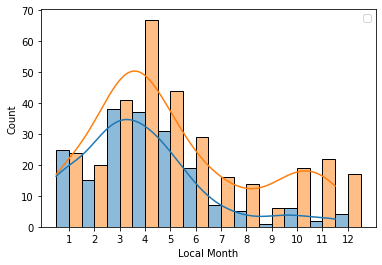

In [59]:
fig, ax = plt.subplots()
_ = sns.histplot(data = df, x = 'Local Month', hue = 'Mechanism redone', hue_order = ['SID', 'PMD'], multiple="dodge", kde = True, \
            bins = [1,2,3,4,5,6,7,8,9,10,11,12,13], stat = 'count')

bin_labels = ['1','2','3','4','5','6','7','8','9','10','11','12']
ax.set_xticks(np.arange(1.5,13.5,1))
ax.set_xticklabels(bin_labels);
ax.legend().set_title('')

In [60]:
df.columns

Index(['Date', 'State ', 'Time (UTC)', 'Local Time', 'Local Hour',
       'Local Month', 'Lat', 'Lon', 'EF Rating', 'Season',
       'Length of QLCS (km)', 'Lowest tilt elevation (m)',
       'ML Circ >15min prior to LL Circ?', 'MLC Strength (kts) (if present)',
       'LLC Strength (kts)', 'LLDV (m/s)', 'LLC<500m', 'Lead Time (min)',
       'Lead Time Non-Zero', 'Adjacent Ciruclation within 25km? ', 'Mechanism',
       'Mechanism redone', 'Comments', 'Not Repeated', 'Path Length (miles)',
       'Width', 'Injuries', 'Deaths', 'Storm Speed (km/hr)', 'Duration (min)',
       'Unnamed: 16', 'Evenly spaced ', 'No ML circulation'],
      dtype='object')

In [61]:
lt = np.where(df['Lowest tilt elevation (m)']<600)[0]

frac_hsi = (df['Mechanism redone'][lt] == 'SID').sum()/lt.shape
frac_tas = (df['Mechanism redone'][lt] == 'PMD').sum()/lt.shape

In [62]:
frac_tas

array([0.48559671])

In [63]:
frac_hsi = np.array([])
frac_tas = np.array([])
tot      = np.array([])

for i in range(0,1750):
    
    lt = np.where(df['Lowest tilt elevation (m)']<2000-i)[0]
    frac_hsi = np.append(frac_hsi, (df['Mechanism redone'][lt] == 'SID').sum()/lt.shape)
    frac_tas = np.append(frac_tas, (df['Mechanism redone'][lt] == 'PMD').sum()/lt.shape)
    tot = np.append(tot, lt.shape)

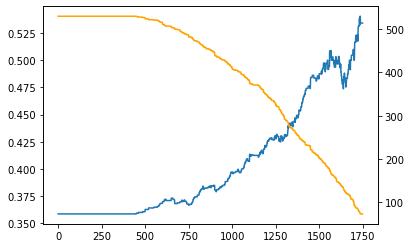

In [64]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.plot(frac_hsi)
ax1.plot(tot, color = 'orange')

In [65]:
# a = [i == 2019 for i in year_list]
# b = [i=='HSI' for i in mechanism_redone]

# n=0
# for i in range(0,len(a)): 
#     if a[i] and b[i]: 
#         n += 1
# n

In [66]:
## 15 cases were skipped during environmental analysis 
## Finding which cases were skipped from environmental analysis
## Datetime vec of tor_dates

time_formal_tor  = [i[:2] + ':' + i[2:4] for i in data_dict['tor_times']]
timevec_tor      = [datetime.strptime(i,'%H:%M') for i in time_formal_tor]
datetime_tor_vec = [datetime.combine(datetime.date(data_dict['tor_dates'][i]), datetime.time(timevec_tor[i])) for i in range(0, len(timevec_tor))]

# Datetime vec of radar_dates
time_formal_radar  = [i[:2] + ':' + i[2:4] for i in radar_times]
timevec_radar      = [datetime.strptime(i,'%H:%M') for i in time_formal_radar]
datetime_radar_vec = [datetime.combine(datetime.date(radar_dates[i]), datetime.time(timevec_radar[i])) for i in range(0, len(timevec_radar))]

In [67]:
#tor_dates[0] in radar_dates
dates1m = within_1min(datetime_radar_vec, datetime_tor_vec)
index_missing = np.array([])
index_data    = np.array([])
    
radar_datetime_str = [i.strftime("%m/%d/%Y, %H:%M") for i in datetime_radar_vec]
tor_datetime_str   = [i.strftime("%m/%d/%Y, %H:%M") for i in datetime_tor_vec]
dates1m_str        = [i.strftime("%m/%d/%Y, %H:%M") for i in dates1m]

j = 0

for i in range(0, len(radar_datetime_str)): 
    #print(j)
    if (radar_datetime_str[i] in tor_datetime_str) | (tor_datetime_str[i-j] in dates1m_str) :
        index_data = np.append(index_data, i)

    else: 
        j = j+1
        #print(tor_datetime_str[523-j])
        print(radar_datetime_str[i])
        index_missing = np.append(index_missing, i)
        


01/04/2019, 10:38
01/04/2019, 11:10
06/16/2019, 03:19
06/16/2019, 04:36
07/07/2019, 01:49
07/19/2016, 19:34
07/20/2016, 01:55


In [68]:
## Deleting radar data that we don't have environmental data for
df_no_env = df.drop(index_missing)

if  not ('LLDV (m/s)' in df_no_env.columns): 
    df_no_env.insert(df_no_env.columns.get_loc('LLC Strength (kts)') + 1, 'LLDV (m/s)', df_no_env['LLC Strength (kts)']/1.94384)

In [69]:
df_no_env = df_no_env.reset_index(drop = True)

In [70]:
perils_index = np.where((df_no_env['Local Month'] != 3 ) & (df_no_env['Local Month'] != 4 ) & (df_no_env['Local Month'] != 5 ))
df_perils = df_no_env.drop(perils_index[0])

In [71]:
repeat_env = [31,65,66,334,359,404,472]

In [72]:
data_dict['div'][460]

0.0008533653846153846

In [73]:
data_dict['tor_dates'][459]

Timestamp('2017-05-19 00:00:00')

In [74]:
np.where(data_dict['div'] > 5*10**-4)[0]

array([  5,  34,  37,  87,  88, 126, 127, 180, 181, 182, 183, 220, 244,
       266, 267, 325, 326, 356, 357, 366, 385, 386, 387, 389, 390, 391,
       392, 394, 395, 399, 414, 431, 432, 436, 459, 460, 461, 462, 463,
       468, 478, 479, 480, 500, 501, 502])

In [75]:
data_dict['tor_times'][5]

'1647'

In [76]:
for k in data_dict:
    print(k)

n_points
tor_dates
tor_times
tor_mech
fgen_925
fgen_area_925
vort_925
vort_area_925
sbcape
sbcin
threecape
threecin
mucape
mucin
mlcape
mlcin
sbcape_model
srh03
srh01
bs01
bs03
bs06
vort
vort_area
fgen
fgen_area
div
div_area
lcl
stp
scp
lr01
lr03
lr36
nst
fgen_850
fgen_area_850
vort_850
vort_area_850
div_850
div_area_850
fgen_700
rh03
rh36
fgen_area_700
vort_700
vort_area_700
div_700
div_area_700
rh_diff


In [77]:
## 66 Cases of clear HSI
x = np.load('./Rap_Obs_full_final_5.npz', allow_pickle = True)

for k in x.files:
    #print(k)
    if k in data_dict:
        #print(k)
        if data_dict[k].size>600:
            print(k)
            df_no_env[k] = tuple(data_dict[k][:,0])  ## Choosing the mean
        else:
            df_no_env[k] = tuple(data_dict[k])
    else:
        pass

sbcape
sbcin
threecape
threecin
mucape
mucin
mlcape
mlcin
sbcape_model
srh03
srh01
bs01
bs03
bs06
lcl
stp
scp
lr01
lr03
lr36
nst
rh03
rh36


In [78]:
df_no_env['rh_diff'] = tuple(data_dict['rh_diff'][:,0]) 

In [79]:
df_no_env_2 = df_no_env.drop(repeat_env)

In [80]:
perils_index = np.where((df_no_env['Local Month'] != 3 ) & (df_no_env['Local Month'] != 4 ) & (df_no_env['Local Month'] != 5 ))
df_perils = df_no_env.drop(perils_index[0])

In [81]:
df_perils.to_excel(r'./march_april_may_env.xlsx', index = False)

In [82]:
# df_no_env['Surface-based CAPE'] = tuple(data_dict['sbcape'][:,0])
# df_no_env['Surface-based CIN']  = tuple(data_dict['sbcin'][:,0])
# df_no_env['Mixed-Layer CAPE']   = tuple(data_dict['mlcape'][:,0])
# df_no_env['MUCAPE']             = tuple(data_dict['mucape'][:,0])
# df_no_env['three_cape']         = tuple(data_dict['threecape'][:,0])

# df_no_env['0-1km SRH'] = tuple(data_dict['srh01'][:,0])
# df_no_env['0-3km SRH'] = tuple(data_dict['srh03'][:,0])
# df_no_env['0-1km Bulk Shear'] = tuple(data_dict['bs01'][:,0])
# df_no_env['0-3km Bulk Shear'] = tuple(data_dict['bs03'][:,0])
# df_no_env['0-6km Bulk Shear'] = tuple(data_dict['bs06'][:,0])

# df_no_env['STP'] = tuple(data_dict['stp'][:,0])
# #df_no_env['RH 0-3'] = tuple(rh03[:,0])
# #df_no_env['RH 3-6'] = tuple(rh36[:,0])

# df_no_env['Vorticity'] = tuple(data_dict['vort'])
# df_no_env['Vorticity Area'] = tuple(data_dict['vort_area'])

# df_no_env['Vorticity 850mb']  = tuple(data_dict['vort_850'])
# df_no_env['Vorticity Area 850mb']  = tuple(data_dict['vort_area_850'])

# df_no_env['Vorticity 700mb']  = tuple(data_dict['vort_700'])
# df_no_env['Vorticity Area 700mb']  = tuple(data_dict['vort_area_700'])

# df_no_env['Fgen'] = tuple(data_dict['fgen'])
# df_no_env['Fgen Area'] = tuple(data_dict['fgen_area'])

# df_no_env['Fgen 850mb']  = tuple(data_dict['fgen_850'])
# df_no_env['Fgen Area 850mb']  = tuple(data_dict['fgen_area_850'])

# df_no_env['Fgen 700mb']  = tuple(data_dict['fgen_700'])
# df_no_env['Fgen Area 700mb']  = tuple(data_dict['fgen_area_700'])


In [83]:
for k in df_no_env_2.columns:
    try:
        print(k)
        hsi_array = np.array(df_no_env_2[k])[np.where(df_no_env_2['Mechanism redone'] == 'SID')]
        tas_array = np.array(df_no_env_2[k])[np.where(df_no_env_2['Mechanism redone'] == 'PMD')]
        print(np.nanmean(hsi_array))
        print(np.nanmean(tas_array))
        #print(hsi_array)
#         print('hsi:', len(hsi_array))
#         print('PMD:', len(tas_array))
        print(ttest_ind(hsi_array, tas_array, nan_policy = 'omit'))
        print('')
        print('')
        print('')
        #print(np.nanmean(np.array(df_no_env[k])[np.where(df_no_env['Mechanism redone'] == 'PMD')]))
    except:
        pass

Date
State 
Time (UTC)
Local Time
Local Hour
13.63888888888889
13.993650793650794
Ttest_indResult(statistic=-0.6035060295804633, pvalue=0.5464496667601199)



Local Month
4.35
5.511111111111111
Ttest_indResult(statistic=-4.2476368902740465, pvalue=2.583277076764997e-05)



Lat
36.295465
35.55634603174603
Ttest_indResult(statistic=1.8365974804364487, pvalue=0.06687121653028814)



Lon
82.69140722222222
59.19517682539683
Ttest_indResult(statistic=4.308236623293238, pvalue=1.9870964667750792e-05)



EF Rating
Season
Length of QLCS (km)
233.45
196.14920634920634
Ttest_indResult(statistic=2.6764079907663727, pvalue=0.007689415730497687)



Lowest tilt elevation (m)
570.7277777777778
741.6634920634921
Ttest_indResult(statistic=-5.023119610974558, pvalue=7.11979946738057e-07)



ML Circ >15min prior to LL Circ?
MLC Strength (kts) (if present)
LLC Strength (kts)
58.016666666666666
67.93015873015872
Ttest_indResult(statistic=-5.708067865340127, pvalue=1.97521846215886e-08)



LLDV (m/s)
29.8464

/tmp/ipykernel_15560/3830996535.py:6: RuntimeWarning: Mean of empty slice
  print(np.nanmean(hsi_array))
/tmp/ipykernel_15560/3830996535.py:7: RuntimeWarning: Mean of empty slice
  print(np.nanmean(tas_array))
/data/keeling/a/jamessg3/miniconda3/lib/python3.8/site-packages/scipy/stats/_mstats_basic.py:1279: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!


(array([ 5., 60., 82., 79., 41., 29., 12.,  5.,  1.,  1.]),
 array([ 25. ,  37.8,  50.6,  63.4,  76.2,  89. , 101.8, 114.6, 127.4,
        140.2, 153. ]),
 <BarContainer object of 10 artists>)

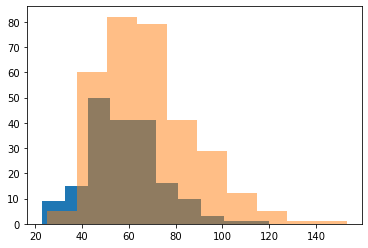

In [84]:
plt.hist(df_no_env['LLC Strength (kts)'][df_no_env['Mechanism redone'] == 'SID'])
plt.hist(df_no_env['LLC Strength (kts)'][df_no_env['Mechanism redone'] == 'PMD'], alpha = 0.5)

In [85]:
 np.array(df_no_env_2['sbcape'])[np.where(df_no_env_2['Mechanism redone'] == 'PMD')]

array([ 173.34616044,  233.88467757,  324.32553437,  171.24577716,
       1280.36675172,  151.52507911, 1440.07075907,  664.43172221,
       1523.71205866,  882.51840147, 1314.92119842, 1178.81729681,
       1216.38125468, 1352.26096601,  479.67703687, 1131.44607807,
        656.43648452,  547.45489901,  577.86203246,  507.31690959,
        520.60657063,  458.55186656,  935.22867704,  247.32558292,
         89.36897653,  987.87831755,  587.93304048, 2103.84515268,
        470.47429274, 1148.82402225,  992.76747181,  552.08808733,
       1281.11401928,  521.59942581,  773.87529618,  454.81238048,
        498.21204081,  453.73458742,  704.55245415,  551.07506625,
        204.94046471,  243.491392  ,  636.76839248,  832.78230943,
        686.67657095,  710.78694276,  724.74145206,  852.59865005,
         34.59896208, 1397.70184825, 1570.15827864,  781.80807942,
        326.19504788,  804.24698322,  460.50963286,  476.76660744,
        800.42106955,  269.71141251,  310.03092838,  673.07546

In [86]:
hsi_locs = np.where(df_no_env['Mechanism redone'] == 'HSI')
(np.array(df_no_env['Lead Time (min)'])[hsi_locs[0]] ==0).sum()

0

In [87]:
for k in df_no_env_2.columns:
    try:
        print(k)
        #print(np.nanmean(np.array(df_no_env_2[k])[np.where(df_no_env_2['Mechanism redone'] == 'SID')]))
        print(ttest_ind(np.array(df_no_env_2[k])[np.where(df_no_env_2['Mechanism redone'] == 'SID')], np.array(df_no_env_2[k])[np.where(df_no_env_2['Mechanism redone'] == 'PMD')]))
    except:
        pass

Date
State 
Time (UTC)
Local Time
Local Hour
Ttest_indResult(statistic=-0.6035060295804633, pvalue=0.5464496667601199)
Local Month
Ttest_indResult(statistic=-4.2476368902740465, pvalue=2.583277076764997e-05)
Lat
Ttest_indResult(statistic=1.8365974804364487, pvalue=0.06687121653028814)
Lon
Ttest_indResult(statistic=4.308236623293238, pvalue=1.9870964667750792e-05)
EF Rating
Season
Length of QLCS (km)
Ttest_indResult(statistic=2.6764079907663727, pvalue=0.007689415730497687)
Lowest tilt elevation (m)
Ttest_indResult(statistic=-5.023119610974558, pvalue=7.11979946738057e-07)
ML Circ >15min prior to LL Circ?
MLC Strength (kts) (if present)
LLC Strength (kts)
Ttest_indResult(statistic=-5.708067865340127, pvalue=1.97521846215886e-08)
LLDV (m/s)
Ttest_indResult(statistic=-5.708067865340134, pvalue=1.9752184621587657e-08)
LLC<500m
Ttest_indResult(statistic=nan, pvalue=nan)
Lead Time (min)
Ttest_indResult(statistic=-1.9066267339463328, pvalue=0.05715001167767444)
Lead Time Non-Zero
Ttest_indRes

In [88]:
df_no_env

,Date,State,Time (UTC),Local Time,Local Hour,Local Month,Lat,Lon,EF Rating,Season,...,div_area_850,fgen_700,rh03,rh36,fgen_area_700,vort_700,vort_area_700,div_700,div_area_700,rh_diff
0,2019-01-19,MS,1338,2019-01-19 07:38:00,7.0,1.0,32.14,90.06,0,Cool,...,100.0,4.257876e-09,0.888641,0.854116,5.0,0.000250,79.0,0.000180,21.0,0.034526
1,2019-01-19,LA,1522,2019-01-19 09:22:00,9.0,1.0,30.81,90.30,1,Cool,...,22.0,2.692130e-09,0.852586,0.715008,0.0,0.000185,22.0,0.000185,20.0,0.137577
2,2019-01-19,LA,1545,2019-01-19 09:45:00,9.0,1.0,30.91,90.09,1,Cool,...,33.0,2.692130e-09,0.839311,0.701685,0.0,0.000161,24.0,0.000200,25.0,0.137626
3,2019-01-19,AL,1947,2019-01-19 13:47:00,13.0,1.0,32.35,86.91,1,Cool,...,37.0,2.047650e-09,0.842004,0.806670,0.0,0.000188,52.0,0.000142,23.0,0.035334
4,2019-01-19,AL,2052,2019-01-19 14:52:00,14.0,1.0,32.52,86.24,2,Cool,...,11.0,3.439776e-09,0.871027,0.829225,4.0,0.000106,7.0,0.000135,8.0,0.041802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,2017-11-18,TN,2230,2017-11-18 16:30:00,16.0,11.0,36.33,86.88,1,Cool,...,86.0,4.404119e-09,0.925629,0.772663,20.0,0.000361,163.0,0.000101,4.0,0.152966
519,2017-11-18,KY,2300,2017-11-18 18:00:00,18.0,11.0,37.42,85.35,1,Cool,...,81.0,5.331628e-09,0.961700,0.889368,18.0,0.000452,223.0,0.000159,26.0,0.072331
520,2017-11-18,AL,2301,2017-11-18 17:01:00,17.0,11.0,34.59,87.74,1,Cool,...,2.0,3.867581e-09,0.878871,0.500260,12.0,0.000209,116.0,0.000079,0.0,0.378611
521,2017-11-18,TN,2304,2017-11-18 17:04:00,17.0,11.0,36.40,86.26,0,Cool,...,106.0,5.331628e-09,0.924353,0.773326,19.0,0.000368,234.0,0.000118,29.0,0.151027


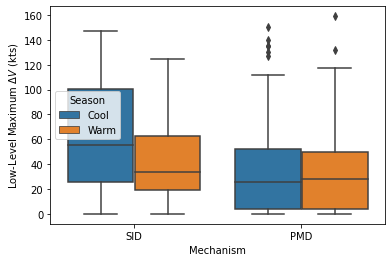

In [89]:
f, ax = plt.subplots()
sns.boxplot(x = 'Mechanism redone' , y = 'fgen_area_700', hue = 'Season', order = ['SID', 'PMD'], data=df_no_env)#, showfliers = False)
plt.xlabel('Mechanism')
plt.ylabel('Low-Level Maximum $\Delta V$ (kts)')
plt.savefig('../Figures/mech_llc.png', dpi = 300 )

Text(0, 0.5, 'Low-Level $\\Delta V$')

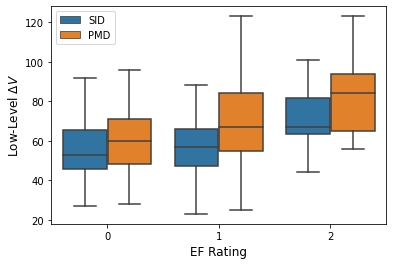

In [90]:
f, ax = plt.subplots()
ax = sns.boxplot(x = 'EF Rating' , y='LLC Strength (kts)',hue = 'Mechanism redone', order = [0,1,2], hue_order = ['SID', 'PMD'], data=df, showfliers = False)
handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles[0:2], labels[0:2])
plt.xlabel('EF Rating', fontsize = 12)
plt.ylabel('Low-Level ' + r'$\Delta V$', fontsize = 12)



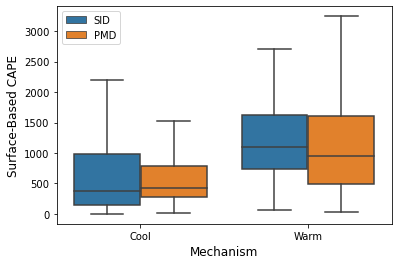

In [91]:
f, ax = plt.subplots()
f.set_size_inches(6, 4)
sns.boxplot(x = 'Season' , y='sbcape', hue = 'Mechanism redone', order = ['Cool', 'Warm'], hue_order = ['SID', 'PMD'], data=df_no_env, showfliers = False)
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('Mechanism', fontsize = 12)
plt.ylabel('Surface-Based CAPE', fontsize = 12)

l = plt.legend(handles[0:2], labels[0:2], loc = 'upper left')

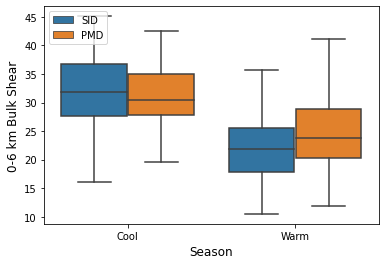

In [92]:
f, ax = plt.subplots()
f.set_size_inches(6, 4)
sns.boxplot(x = 'Season' , y='bs06', hue = 'Mechanism redone', order = ['Cool', 'Warm'], hue_order = ['SID', 'PMD'], data=df_no_env, showfliers = False)
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('Season', fontsize = 12)
plt.ylabel('0-6 km Bulk Shear', fontsize = 12)

l = plt.legend(handles[0:2], labels[0:2], loc = 'upper left')

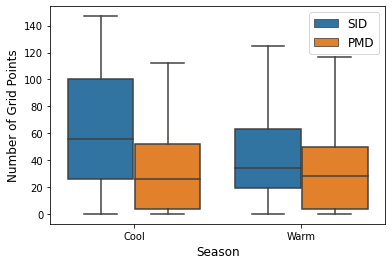

In [93]:
f, ax = plt.subplots()
f.set_size_inches(6, 4)
sns.boxplot(x = 'Season' , y='fgen_area_700', hue = 'Mechanism redone', order = ['Cool', 'Warm'], hue_order = ['SID', 'PMD'], data=df_no_env, showfliers = False)
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('Season', fontsize = 12)
plt.ylabel('Number of Grid Points', fontsize = 12)

l = plt.legend(handles[0:2], labels[0:2], loc = 'upper right', fontsize = 12)
f.savefig("../Figures/Rev2/fig13.png", bbox_inches='tight', dpi = 700) 

In [94]:
df_no_env.columns

Index(['Date', 'State ', 'Time (UTC)', 'Local Time', 'Local Hour',
       'Local Month', 'Lat', 'Lon', 'EF Rating', 'Season',
       'Length of QLCS (km)', 'Lowest tilt elevation (m)',
       'ML Circ >15min prior to LL Circ?', 'MLC Strength (kts) (if present)',
       'LLC Strength (kts)', 'LLDV (m/s)', 'LLC<500m', 'Lead Time (min)',
       'Lead Time Non-Zero', 'Adjacent Ciruclation within 25km? ', 'Mechanism',
       'Mechanism redone', 'Comments', 'Not Repeated', 'Path Length (miles)',
       'Width', 'Injuries', 'Deaths', 'Storm Speed (km/hr)', 'Duration (min)',
       'Unnamed: 16', 'Evenly spaced ', 'No ML circulation', 'n_points',
       'tor_dates', 'tor_times', 'tor_mech', 'fgen_925', 'fgen_area_925',
       'vort_925', 'vort_area_925', 'sbcape', 'sbcin', 'threecape', 'threecin',
       'mucape', 'mucin', 'mlcape', 'mlcin', 'sbcape_model', 'srh03', 'srh01',
       'bs01', 'bs03', 'bs06', 'vort', 'vort_area', 'fgen', 'fgen_area', 'div',
       'div_area', 'lcl', 'stp', 'scp', 

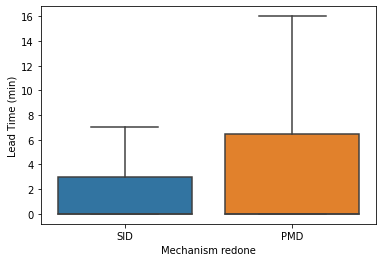

In [95]:
#sns.boxplot(x= 'Mechanism redone', y='Lead Time (min)', data=df_no_env, order = ['HSI', 'PMD'], showfliers = False)
sns.boxplot(x= 'Mechanism redone', y='Lead Time (min)', data=df,  order = ['SID', 'PMD'], showfliers = False)
plt.show()
#sns.swarmplot(x=df_no_env['Mechanism_redone'], y="Fgen Area 700mb",hue="Season", data=df_no_env)

<AxesSubplot:xlabel='Local Hour', ylabel='Count'>

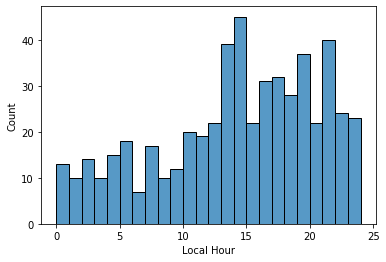

In [96]:
sns.histplot(data = df, x = 'Local Hour', bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

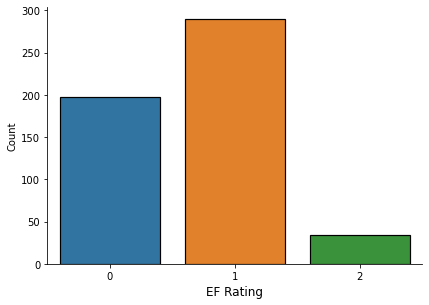

In [97]:

g = sns.catplot(data = df, x = 'EF Rating', order = [0,1,2], kind="count")

plt.setp(g.ax.patches, edgecolor = 'black', lw = 1.2)
#g.xlabel_fontsize = 16
plt.ylabel('')
plt.xlabel('EF Rating', fontsize = 12)
g.ax.patch.set_edgecolor('black')
plt.ylabel('Count')
#plt.xlabel(fontsize = 12)
g.fig.set_size_inches(6,4)
#g.savefig('../Figures/ef_count.png', dpi = 500 )


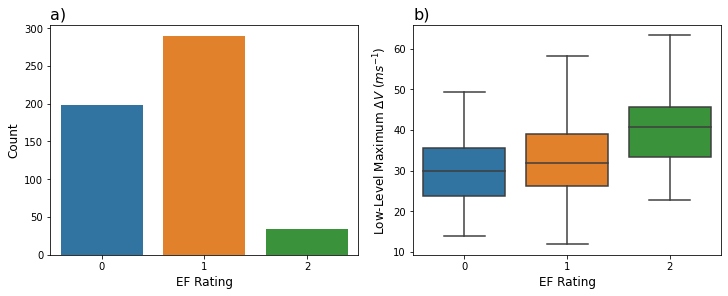

In [98]:
## Figure 7

fig, axs = plt.subplot_mosaic([['a)', 'b)']],
                              constrained_layout=True, figsize=(10,4))


g = sns.countplot(data = df, x = 'EF Rating', order = [0,1,2], ax=axs['a)'])

#axs['a)'].setp(g.ax.patches, edgecolor = 'black', lw = 1.2)
#g.xlabel_fontsize = 16
axs['a)'].set_ylabel('')
axs['a)'].set_xlabel('EF Rating', fontsize = 12)
axs['a)'].patch.set_edgecolor('black')
axs['a)'].set_ylabel('Count', fontsize = 12)
#plt.xlabel(fontsize = 12)
#g.fig.set_size_inches(6,4)
#g.savefig('../Figures/ef_count.png', dpi = 500 )

g = sns.boxplot(x='EF Rating', y = 'LLDV (m/s)', data=df, order = [0,1,2], showfliers = False, ax = axs['b)'])
plt.xlabel('EF Rating', fontsize = 12)
plt.ylabel('Low-Level Maximum $\Delta V$ ($m s^{-1}$)', fontsize = 12)

for label, ax in axs.items():
    ax.set_title('', fontstyle='italic')
    ax.set_title(label, fontfamily='sans_serif', loc='left', fontsize=16)


fig.savefig("../Figures/fig7.png", bbox_inches='tight', dpi = 1000) 

No handles with labels found to put in legend.


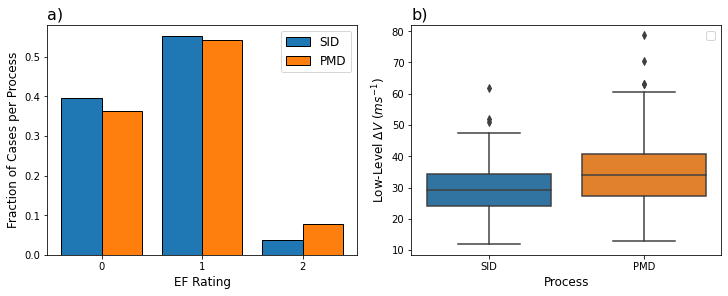

In [101]:
## Figure 8

fig, axs = plt.subplot_mosaic([['a)', 'b)']],
                              constrained_layout=True, figsize=(10,4))



axs['a)'].bar(np.arange(0,3)-0.2, frac_ef_hsi, width=0.4, align='center', label = 'SID', edgecolor = 'black')
axs['a)'].bar(np.arange(0,3)+0.2, frac_ef_tas, width=0.4, align='center', label = 'PMD', edgecolor = 'black')

axs['a)'].set_xticks([0, 1, 2])
axs['a)'].legend(fontsize = 12)
axs['a)'].set_xlabel('EF Rating', fontsize = 12)
axs['a)'].set_ylabel('Fraction of Cases per Process', fontsize = 12)


axs['b)'] = sns.boxplot(x = 'Mechanism redone' , y = 'LLDV (m/s)', order = ['SID', 'PMD'], data=df, ax = axs['b)']) ## Figure 9a
axs['b)'].set_xlabel('Process', fontsize = 12)
axs['b)'].set_ylabel('Low-Level '+ r'$\Delta V$ ($m s^{-1}$)', fontsize = 12)
axs['b)'].legend(fontsize = 12)


for label, ax in axs.items():
    ax.set_title('', fontstyle='italic')
    ax.set_title(label, fontfamily='sans_serif', loc='left', fontsize=16)


fig.savefig("../Figures/Rev2/fig9.png", bbox_inches='tight', dpi = 1000) 

In [100]:
dvh = np.array(df['LLDV (m/s)'])[np.where(df['Mechanism redone'] == 'SID')]
dvt = np.array(df['LLDV (m/s)'])[np.where(df['Mechanism redone'] == 'PMD')]

np.percentile(dvh, 90)

40.12675940406618

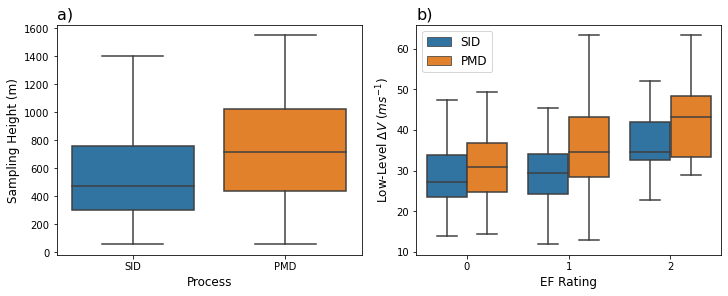

In [102]:
## Figure 9
plt.close()

fig, axs = plt.subplot_mosaic([['a)', 'b)']],
                              constrained_layout=True, figsize=(10,4))



sns.boxplot(x = 'Mechanism redone' , y = 'Lowest tilt elevation (m)', order = ['SID', 'PMD'], data=df, ax = axs['a)']) ## Figure 9a
axs['a)'].set_xlabel('Process', fontsize = 12)
axs['a)'].set_ylabel('Sampling Height (m)', fontsize = 12)



axs['b)'] = sns.boxplot(x = 'EF Rating' , y='LLDV (m/s)',hue = 'Mechanism redone', order = [0,1,2], hue_order = ['SID', 'PMD'], data=df, showfliers = False, ax = axs['b)'])
handles, labels = axs['b)'].get_legend_handles_labels()

l = axs['b)'].legend(handles[0:2], labels[0:2], fontsize = 12)
axs['b)'].set_xlabel('EF Rating', fontsize = 12)
axs['b)'].set_ylabel('Low-Level ' + r'$\Delta V$ ($m s^{-1}$)', fontsize = 12)
#axs['b)'].legend(fontsize = 12)


for label, ax in axs.items():
    ax.set_title('', fontstyle='italic')
    ax.set_title(label, fontfamily='sans_serif', loc='left', fontsize=16)


fig.savefig("../Figures/Rev2/fig10.png", bbox_inches='tight', dpi = 1000) 

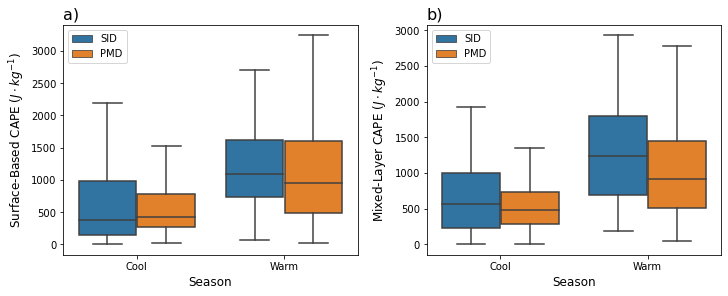

In [245]:
## Figure 10


fig, axs = plt.subplot_mosaic([['a)', 'b)']],
                              constrained_layout=True, figsize=(10,4))



sns.boxplot(x = 'Season' , y='sbcape', hue = 'Mechanism redone', order = ['Cool', 'Warm'], hue_order = ['SID', 'PMD'], data=df_no_env, showfliers = False, ax = axs['a)'])
handles, labels = axs['a)'].get_legend_handles_labels()
axs['a)'].set_xlabel('Season', fontsize = 12)
axs['a)'].set_ylabel('Surface-Based CAPE ($J \cdot kg^{-1}$)', fontsize = 12)

l = axs['a)'].legend(handles[0:2], labels[0:2], loc = 'upper left')



sns.boxplot(x = 'Season' , y='mlcape', hue = 'Mechanism redone', order = ['Cool', 'Warm'], hue_order = ['SID', 'PMD'], data=df_no_env, showfliers = False, ax = axs['b)'])
handles, labels = axs['b)'].get_legend_handles_labels()
axs['b)'].set_xlabel('Season', fontsize = 12)
axs['b)'].set_ylabel('Mixed-Layer CAPE ($J\cdot kg^{-1}$)', fontsize = 12)

l = axs['b)'].legend(handles[0:2], labels[0:2], loc = 'upper left')
#axs['b)'].legend(fontsize = 12)


for label, ax in axs.items():
    ax.set_title('', fontstyle='italic')
    ax.set_title(label, fontfamily='sans_serif', loc='left', fontsize=16)


fig.savefig("../Figures/Rev2/fig11.png", bbox_inches='tight', dpi = 1000) 

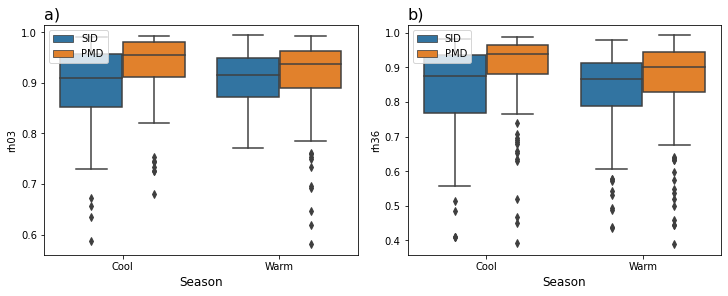

In [131]:
## Figure 10


fig, axs = plt.subplot_mosaic([['a)', 'b)']],
                              constrained_layout=True, figsize=(10,4))



sns.boxplot(x = 'Season' , y='rh03', hue = 'Mechanism redone', order = ['Cool', 'Warm'], hue_order = ['SID', 'PMD'], data=df_no_env, showfliers = True, ax = axs['a)'])
handles, labels = axs['a)'].get_legend_handles_labels()
axs['a)'].set_xlabel('Season', fontsize = 12)
#axs['a)'].set_ylabel('Surface-Based CAPE ($J \cdot kg^{-1}$)', fontsize = 12)

l = axs['a)'].legend(handles[0:2], labels[0:2], loc = 'upper left')



sns.boxplot(x = 'Season' , y='rh36', hue = 'Mechanism redone', order = ['Cool', 'Warm'], hue_order = ['SID', 'PMD'], data=df_no_env, showfliers = True, ax = axs['b)'])
handles, labels = axs['b)'].get_legend_handles_labels()
axs['b)'].set_xlabel('Season', fontsize = 12)
#axs['b)'].set_ylabel('Mixed-Layer CAPE ($J\cdot kg^{-1}$)', fontsize = 12)

l = axs['b)'].legend(handles[0:2], labels[0:2], loc = 'upper left')
#axs['b)'].legend(fontsize = 12)


for label, ax in axs.items():
    ax.set_title('', fontstyle='italic')
    ax.set_title(label, fontfamily='sans_serif', loc='left', fontsize=16)


#fig.savefig("../Figures/fig10.png", bbox_inches='tight', dpi = 1000) 

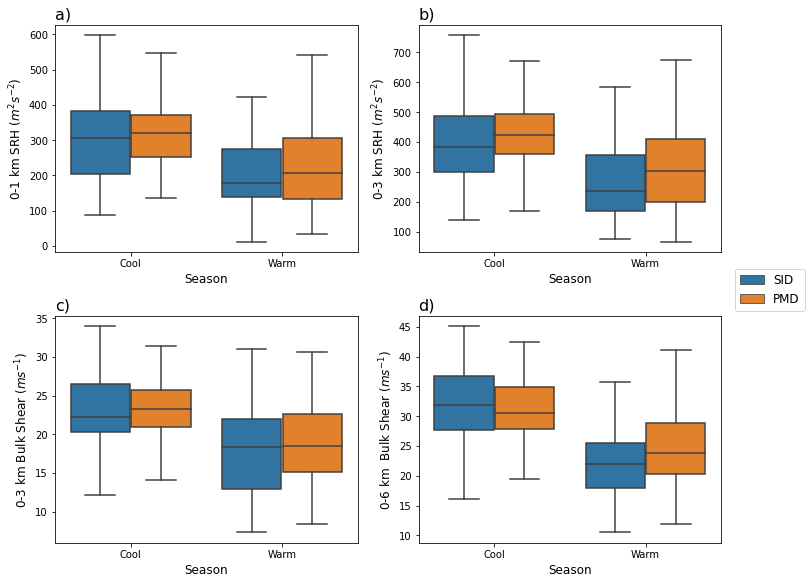

In [246]:
## Figure 11

fig, axs = plt.subplot_mosaic([['a)', 'b)'], ['c)', 'd)']],
                              constrained_layout=True, figsize=(10,8))

sns.boxplot(x = 'Season' , y='srh01', hue = 'Mechanism redone', order = ['Cool', 'Warm'], hue_order = ['SID', 'PMD'], data=df_no_env, showfliers = False, ax = axs['a)'])
#handles, labels = axs['a)'].get_legend_handles_labels()
axs['a)'].set_xlabel('Season', fontsize = 12)
axs['a)'].set_ylabel('0-1 km SRH ($m^2 s^{-2}$)', fontsize = 12)

fig.legend(bbox_to_anchor=(1.12, 0.55), loc='upper right', fontsize = 12)
#l = axs['a)'].legend(handles[0:2], labels[0:2], loc = 'upper left', fontsize = 12)



sns.boxplot(x = 'Season' , y='srh03', hue = 'Mechanism redone', order = ['Cool', 'Warm'], hue_order = ['SID', 'PMD'], data=df_no_env, showfliers = False, ax = axs['b)'])
#handles, labels = axs['b)'].get_legend_handles_labels()
axs['b)'].set_xlabel('Season', fontsize = 12)
axs['b)'].set_ylabel('0-3 km SRH ($m^2 s^{-2}$)', fontsize = 12)

#l = axs['b)'].legend(handles[0:2], labels[0:2], loc = 'upper left', fontsize = 12)

sns.boxplot(x = 'Season' , y='bs03', hue = 'Mechanism redone', order = ['Cool', 'Warm'], hue_order = ['SID', 'PMD'], data=df_no_env, showfliers = False, ax = axs['c)'])
#handles, labels = axs['b)'].get_legend_handles_labels()
axs['c)'].set_xlabel('Season', fontsize = 12)
axs['c)'].set_ylabel('0-3 km Bulk Shear ($m s^{-1}$)', fontsize = 12)

#l = axs['c)'].legend(handles[0:2], labels[0:2], loc = 'upper left', fontsize = 12)

sns.boxplot(x = 'Season' , y='bs06', hue = 'Mechanism redone', order = ['Cool', 'Warm'], hue_order = ['SID', 'PMD'], data=df_no_env, showfliers = False, ax = axs['d)'])
#handles, labels = axs['b)'].get_legend_handles_labels()
axs['d)'].set_xlabel('Season', fontsize = 12)
axs['d)'].set_ylabel('0-6 km  Bulk Shear ($m s^{-1}$)', fontsize = 12)

#l = axs['d)'].legend(handles[0:2], labels[0:2], loc = 'upper left', fontsize = 12)
axs['a)'].get_legend().remove()
axs['b)'].get_legend().remove()
axs['c)'].get_legend().remove()
axs['d)'].get_legend().remove()
#fig.legend(bbox_to_anchor=(1.05, 1.0), loc='upper right')

for label, ax in axs.items():
    ax.set_title('', fontstyle='italic')
    ax.set_title(label, fontfamily='sans_serif', loc='left', fontsize=16)


fig.savefig("../Figures/Rev2/fig12.png", bbox_inches='tight', dpi = 800)

In [107]:
y_var = ['Length of QLCS (km)', 'Lowest tilt elevation (m)', 'LLC Strength (kts)']

for i in df_no_env.columns[df_no_env.columns.get_loc('sbcape'):]:
    y_var.append(i)
y_var  

['Length of QLCS (km)',
 'Lowest tilt elevation (m)',
 'LLC Strength (kts)',
 'sbcape',
 'sbcin',
 'threecape',
 'threecin',
 'mucape',
 'mucin',
 'mlcape',
 'mlcin',
 'sbcape_model',
 'srh03',
 'srh01',
 'bs01',
 'bs03',
 'bs06',
 'vort',
 'vort_area',
 'fgen',
 'fgen_area',
 'div',
 'div_area',
 'lcl',
 'stp',
 'scp',
 'lr01',
 'lr03',
 'lr36',
 'nst',
 'fgen_850',
 'fgen_area_850',
 'vort_850',
 'vort_area_850',
 'div_850',
 'div_area_850',
 'fgen_700',
 'rh03',
 'rh36',
 'fgen_area_700',
 'vort_700',
 'vort_area_700',
 'div_700',
 'div_area_700']

In [108]:
## No Hue

# x_var = 'Mechanism redone'

# for i in y_var: 
#     file_name = x_var + '_' + i + '_' 
#     sns.boxplot(x=x_var, y= i, data=df_no_env, order=['PMD', 'HSI'], showfliers = False)
#     plt.show()
#     plt.savefig('./env_figures/' + file_name + '.png')
#     plt.close()

In [122]:
# Cool vs Warm hue

x_var = 'Mechanism redone'

for i in y_var: 
    file_name = x_var + '_' + i + '_' + 'season'
    sns.boxplot(x=df_no_env['Mechanism redone'], y= df_no_env[i], data=df_no_env, hue = 'Season', order=['SID', 'PMD'], showfliers = False)#, 'Clear HSI'],  showfliers = False)
    plt.legend(loc='upper right', title = 'EF Rating')
    plt.xlabel('Mechanism')
    plt.tight_layout()
    plt.show()
#     plt.savefig('./env_figures/' + file_name + '.png')
    plt.close()

NameError: name 'y_var' is not defined

No handles with labels found to put in legend.


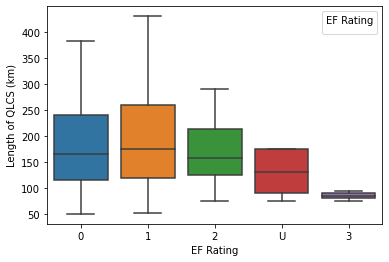

No handles with labels found to put in legend.


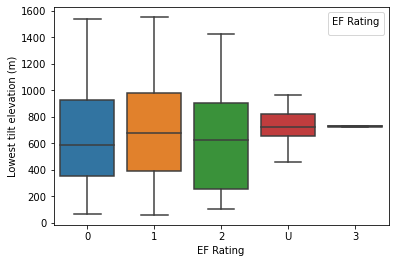

No handles with labels found to put in legend.


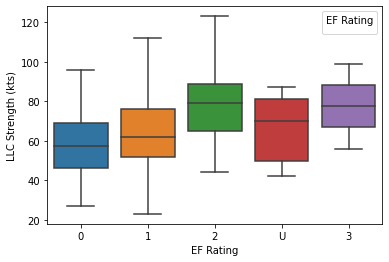

No handles with labels found to put in legend.


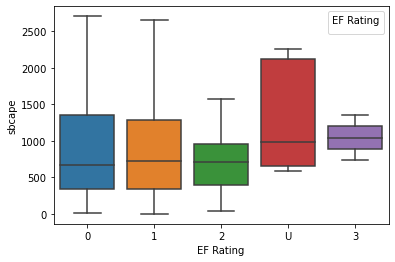

No handles with labels found to put in legend.


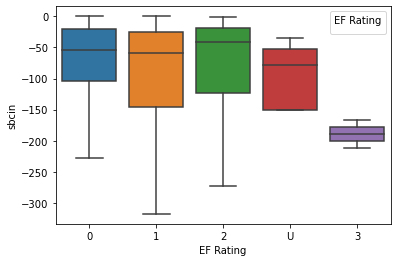

No handles with labels found to put in legend.


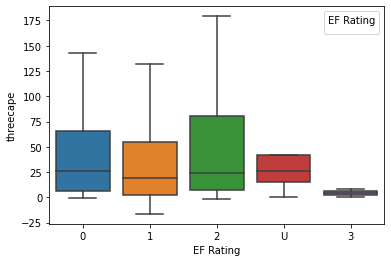

No handles with labels found to put in legend.


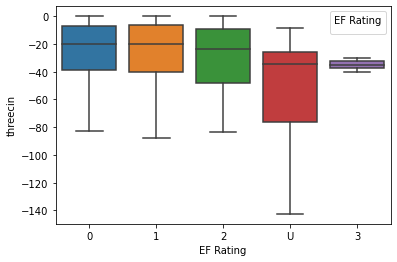

No handles with labels found to put in legend.


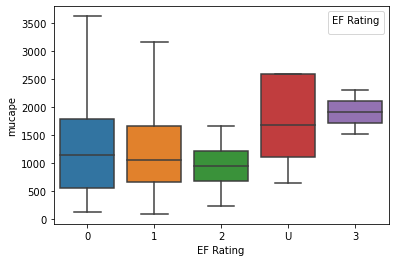

No handles with labels found to put in legend.


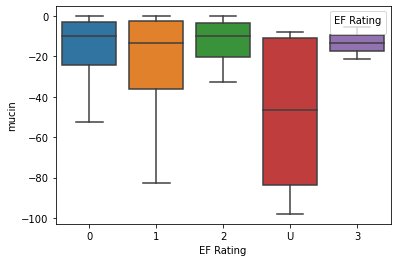

No handles with labels found to put in legend.


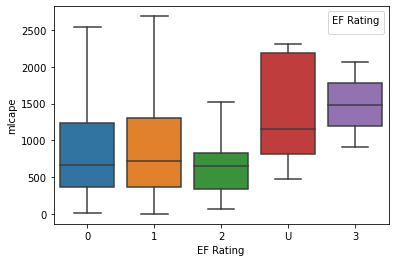

No handles with labels found to put in legend.


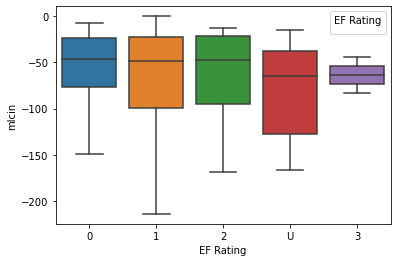

No handles with labels found to put in legend.


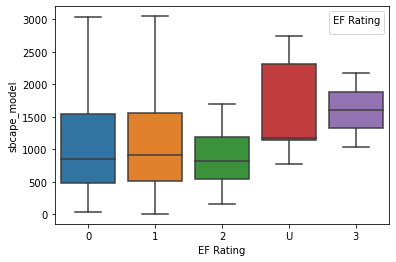

No handles with labels found to put in legend.


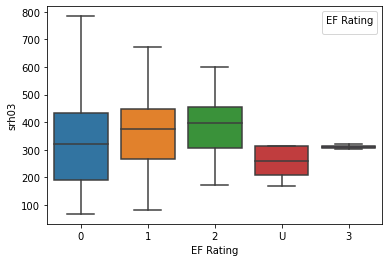

No handles with labels found to put in legend.


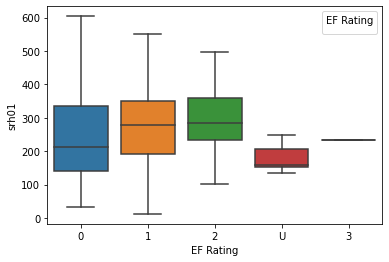

No handles with labels found to put in legend.


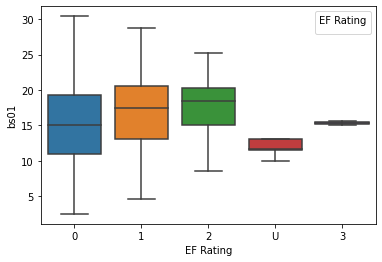

No handles with labels found to put in legend.


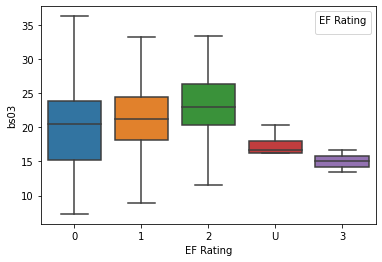

No handles with labels found to put in legend.


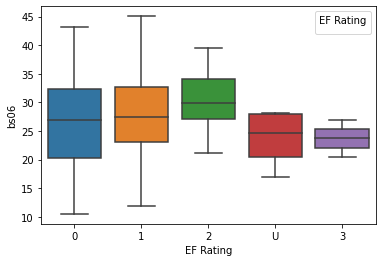

No handles with labels found to put in legend.


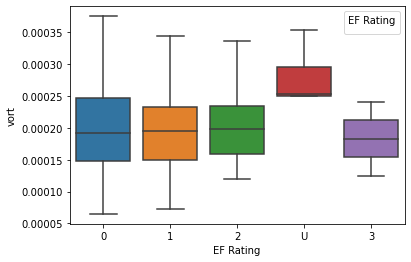

No handles with labels found to put in legend.


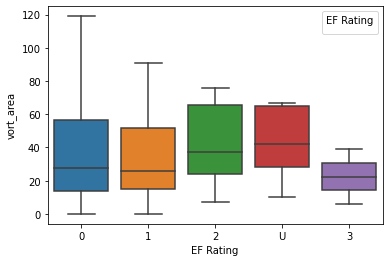

No handles with labels found to put in legend.


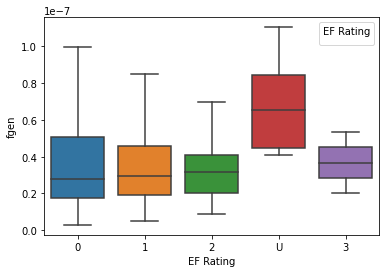

No handles with labels found to put in legend.


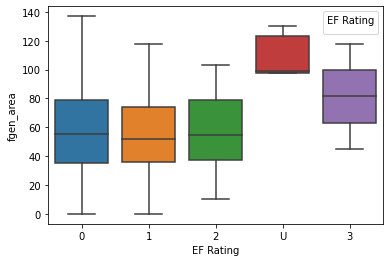

No handles with labels found to put in legend.


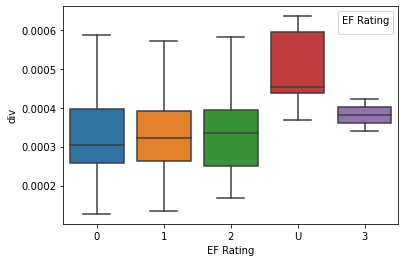

No handles with labels found to put in legend.


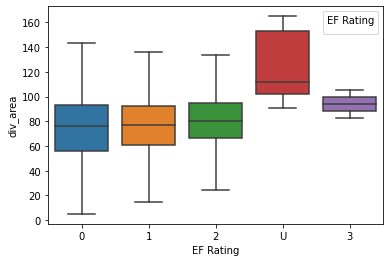

No handles with labels found to put in legend.


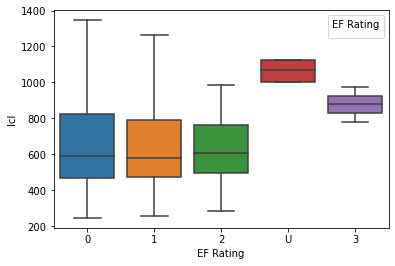

No handles with labels found to put in legend.


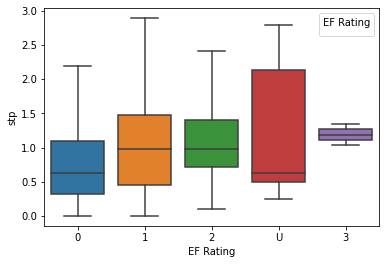

No handles with labels found to put in legend.


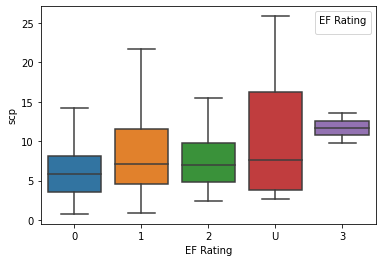

No handles with labels found to put in legend.


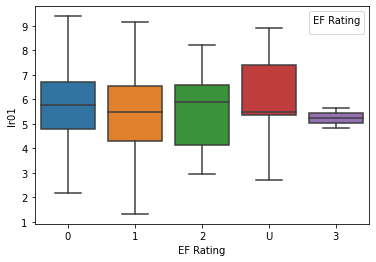

No handles with labels found to put in legend.


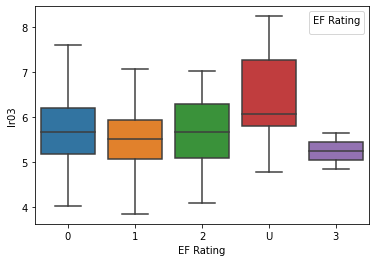

No handles with labels found to put in legend.


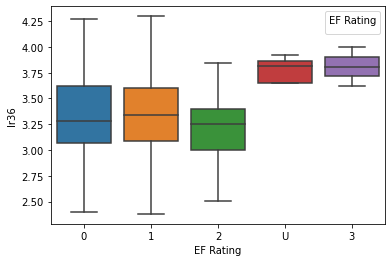

No handles with labels found to put in legend.


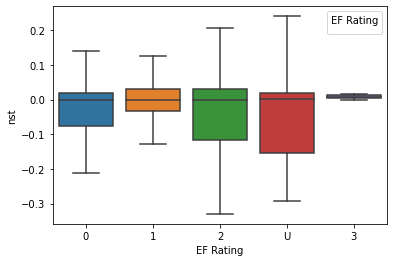

No handles with labels found to put in legend.


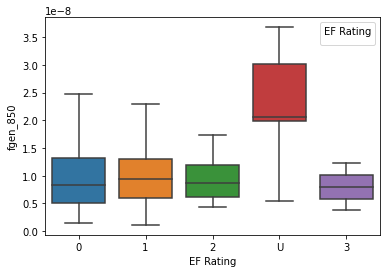

No handles with labels found to put in legend.


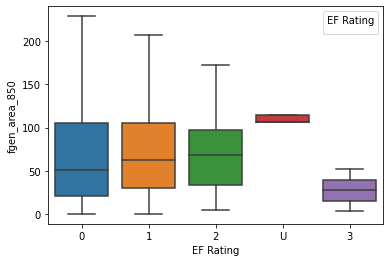

No handles with labels found to put in legend.


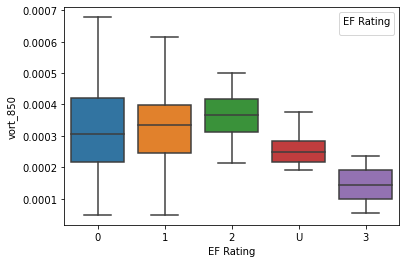

No handles with labels found to put in legend.


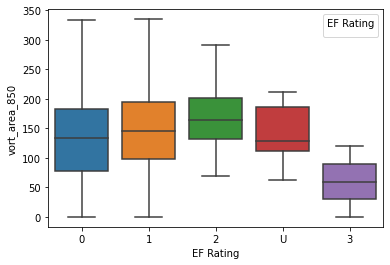

No handles with labels found to put in legend.


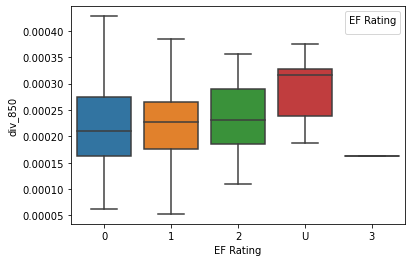

No handles with labels found to put in legend.


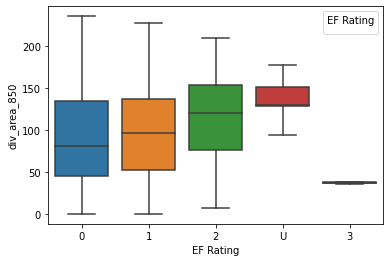

No handles with labels found to put in legend.


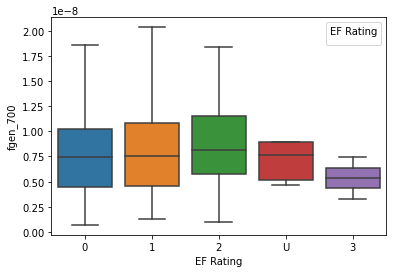

No handles with labels found to put in legend.


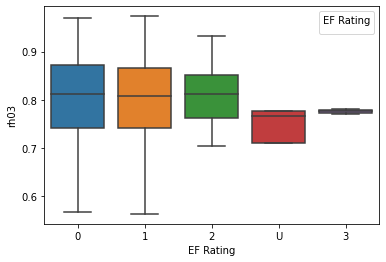

No handles with labels found to put in legend.


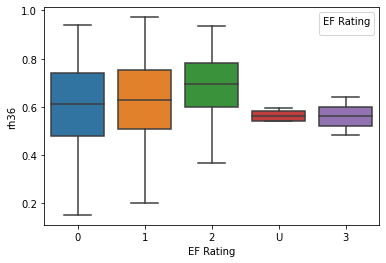

No handles with labels found to put in legend.


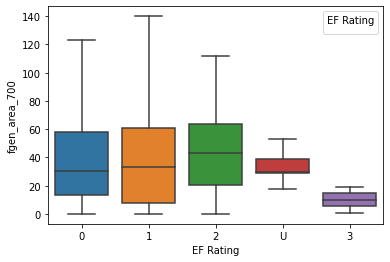

No handles with labels found to put in legend.


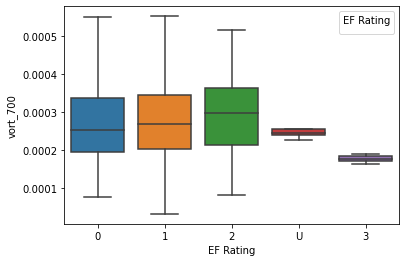

No handles with labels found to put in legend.


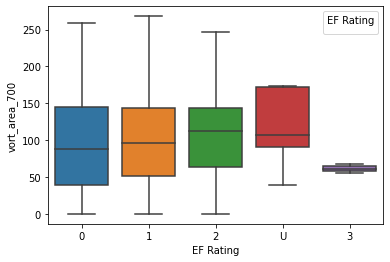

No handles with labels found to put in legend.


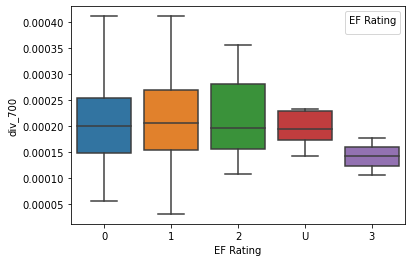

No handles with labels found to put in legend.


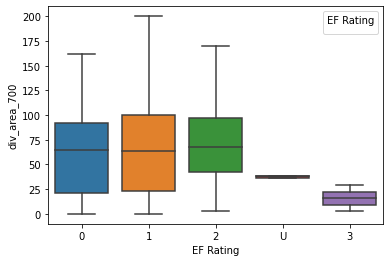

In [110]:
## EF Hue
x_var = 'EF Rating'

for i in y_var: 
    file_name = 'EF Rating' + '_' + i + '_' + 'ef'
    sns.boxplot(x=x_var, y = i, data=df_no_env, showfliers = False)
    plt.legend(loc='upper right', title = 'EF Rating')
    plt.show()
    #plt.savefig('./env_figures/' + file_name + '.png')
    plt.close()

In [111]:
x = ['Length of QLCS', 'Lowest Tilt Elevation', 'LLC Strength  (kts)']

<AxesSubplot:xlabel='Mechanism redone', ylabel='rh_diff'>

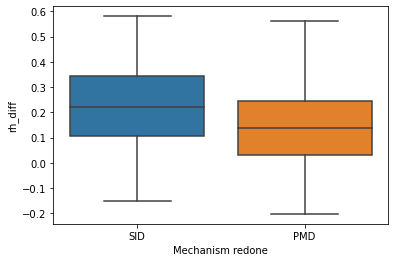

In [124]:
sns.boxplot(x='Mechanism redone', y= 'rh_diff', data=df_no_env, order=['SID', 'PMD'], showfliers = False)#, 'Clear HSI'],  showfliers = False)


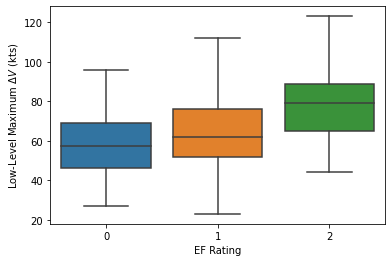

In [112]:
g = sns.boxplot(x='EF Rating', y = 'LLC Strength (kts)', data=df_no_env, order = [0,1,2], showfliers = False)
plt.xlabel('EF Rating')
plt.ylabel('Low-Level Maximum $\Delta V$ (kts)')
plt.savefig('../Figures/ef_llc.png', dpi = 500 )


In [113]:
n = 0
for i in range(0,len(datetime_radar_vec)):
    if (datetime_radar_vec[i].year == 2017): #& ('HSI' in df['Mechanism'][i]):
        n += 1
        

In [114]:
((df['Lat']>37)&(df['Mechanism redone'] == 'PMD')).sum()

108

In [115]:
(df['EF Rating'] == 'U').sum()


6

In [116]:
df['Mechanism redone']

0        H&S
1        H&S
2      Other
3        T&S
4        T&S
       ...  
525      T&S
526      T&S
527      T&S
528      T&S
529      T&S
Name: Mechanism redone, Length: 530, dtype: object

In [117]:
i


529

In [118]:
##38.6% of HSI cases occured north of 37N


In [119]:
df_no_env.columns

Index(['Date', 'State ', 'Time (UTC)', 'Local Time', 'Local Hour',
       'Local Month', 'Lat', 'Lon', 'EF Rating', 'Season',
       'Length of QLCS (km)', 'Lowest tilt elevation (m)',
       'ML Circ >15min prior to LL Circ?', 'MLC Strength (kts) (if present)',
       'LLC Strength (kts)', 'LLDV (m/s)', 'LLC<500m', 'Lead Time (min)',
       'Lead Time Non-Zero', 'Adjacent Ciruclation within 25km? ', 'Mechanism',
       'Mechanism redone', 'Comments', 'Clear HSI?', 'Not Repeated',
       'Path Length (miles)', 'Width', 'Injuries', 'Deaths', 'Unnamed: 16',
       'Evenly spaced ', 'No ML circulation', 'n_points', 'tor_dates',
       'tor_times', 'tor_mech', 'fgen_925', 'fgen_area_925', 'vort_925',
       'vort_area_925', 'sbcape', 'sbcin', 'threecape', 'threecin', 'mucape',
       'mucin', 'mlcape', 'mlcin', 'sbcape_model', 'srh03', 'srh01', 'bs01',
       'bs03', 'bs06', 'vort', 'vort_area', 'fgen', 'fgen_area', 'div',
       'div_area', 'lcl', 'stp', 'scp', 'lr01', 'lr03', 'lr36', 'ns

In [120]:
(df['EF Rating'] == 3).sum()

2

In [354]:
np.mean(df['Duration'][(df['Mechanism redone'] == 'PMD')])

323.69905956112854

In [353]:
np.mean(df['Duration'][(df['Mechanism redone'] == 'SID')])

253.57894736842104

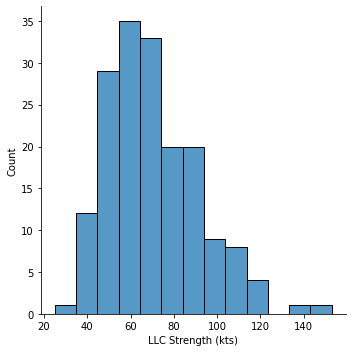

In [97]:
sns.displot(df_no_env, x=df['LLC Strength (kts)'][(df['EF Rating'] == 1) & (df['Mechanism redone'] == 'PMD')])

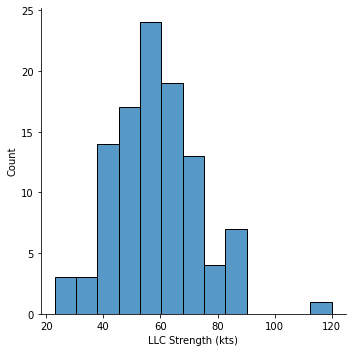

In [98]:
sns.displot(df_no_env, x=df['LLC Strength (kts)'][(df['EF Rating'] == 1) & (df['Mechanism redone'] == 'SID')])

/data/keeling/a/jamessg3/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/keeling/a/jamessg3/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='LLC Strength (kts)', ylabel='EF Rating'>

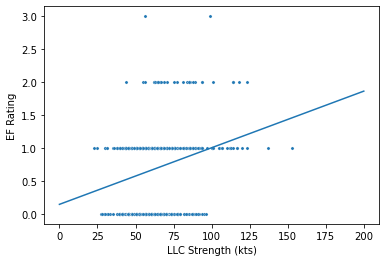

In [99]:
## EF vs max delta V 

xxx = ((df['EF Rating'] == 0) | (df['EF Rating'] == 1) | (df['EF Rating'] == 2) | (df['EF Rating'] == 3))
[a, b] = np.polyfit(np.array(df['LLC Strength (kts)'][xxx], dtype='float'), np.array(df['EF Rating'][xxx], dtype='float'), 1)

sns.scatterplot(df['LLC Strength (kts)'][xxx], df['EF Rating'][xxx],  s=10)
sns.lineplot(np.linspace(0,200,1000), a*np.linspace(0,200,1000) + b)

In [100]:
np.polyfit(np.array(df['LLC Strength (kts)'][xxx], dtype='float'), np.array(df['EF Rating'][xxx], dtype='float'), 1)

array([0.00859132, 0.14504183])

ValueError: Could not interpret input 'Hour Bin'

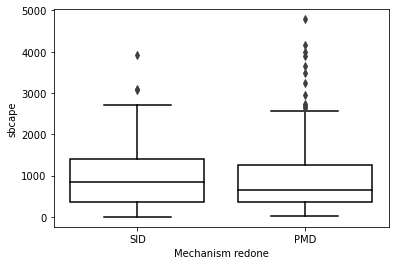

In [101]:
var = 'sbcape'
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

sns.boxplot(x = 'Mechanism redone', y = var, data = df_no_env, order = ['SID','PMD'], **PROPS)
sns.swarmplot(x = 'Mechanism redone', y = var, hue = 'Hour Bin', order = ['SID','PMD'],data = df_no_env, size = 4), #colors = ['red', 'blue'])

In [ ]:
hour_bin = np.array([])

for i in df_no_env['Local Hour']:
    hour_bin = np.append(hour_bin, i // 4)

In [ ]:
df_no_env['Hour Bin'] = hour_bin

In [ ]:
## Formatting for word document


datetime_arr = np.array(datetime_vec)

date_arr = [i.strftime("%m/%d/%Y %H%M") for i in datetime_arr]
dates = [datetime.strptime(i, "%m/%d/%Y %H%M") for i in date_arr]


#dates.sort()

In [ ]:
## Making a dates array

dates_str = [i.strftime("%m/%d/%Y %H%M") for i in dates]



In [ ]:
## Making a lat/lon array
lats = np.array(lat)
lons = np.array(lon)

lats_str = [str(round(i,2)) + ', ' for i in lats]
lons_str = [str(np.abs(round(i,2))) for i in lons]

In [ ]:
lat_lon_str = [lats_str[i] + lons_str[i] for i in range(0,len(lats_str))]



In [ ]:
## Our mechanism array is 'mechanism_redone'

data_dict = {'Date/Time': dates_str, 'Lat/Lon': lat_lon_str, 'Mechanism': mechanism_redone, 'DateTime': datetime_vec}

df_word = pd.DataFrame(data = data_dict)

In [ ]:
df_word = df_word.sort_values(by=['DateTime'])

In [ ]:
arr = np.array([df_word['Date/Time'], df_word['Lat/Lon'], df_word['Mechanism']]).T

In [ ]:
mt = np.empty((4,3), int)

arr2 = np.append(arr, mt, axis = 0)


arr3 = np.reshape(arr2, (-1,9))
#arr3 = arr3[:, :]

mt_slice = np.array(['Date/Time (UTC)', 'Lat/Lon', 'TG MODE', 'Date/Time (UTC)', 'Lat/Lon', 'TG MODE','Date/Time (UTC)', 'Lat/Lon', 'TG MODE'])

In [ ]:
arr4 = np.insert(arr3, [0, 45, 89, 133], mt_slice, axis = 0 )

In [ ]:
arr4

In [ ]:
df_word2 = pd.DataFrame(arr4)

In [ ]:
df_word2.to_excel('appA.xlsx', index=False)